In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import  GridSpec
import numpy as np
from matplotlib.lines import Line2D

from matplotlib import colors
from matplotlib import cm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from osgeo import gdal
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
import fiona
import rasterio
from rasterio.plot import show

import os
import richdem as rd

#import elevation

import glob
%matplotlib inline

In [2]:
#https://trac.osgeo.org/gdal/browser/trunk/autotest/utilities/test_gdalwarp_lib.py

In [3]:
if os.getlogin() == 'joanm':
    bog_gis_dir = 'C:\\Users\\joanm\\OneDrive - Dartmouth College\\PSU_dissertation\\BMbog_paper\\bog_data_clean_for_plots\\bog_gis'
elif os.getlogin() == 'f005dv1':
    bog_gis_dir = 'E:\\Del_Vecchio_OneDrive\\OneDrive - Dartmouth College\\PSU_dissertation\\BMbog_paper\\bog_data_clean_for_plots\\bog_gis'

# Overview map

I tried to figure out how to download files off of PAMAP's servers, but when I discovered wget doesn't work for Windows, I gave up. If you are reading this and want the file URLS let me know. A day may come when I edit the notebook appropriately...

![viggo](https://c.tenor.com/dVQkexYhBMUAAAAC/lord-of-the-rings-lotr.gif)

## Get PAMAP-derived DEMs and imagery and make them lat/long

OK I lost my mind over this but it's kind of GIS 101 embarrassingly enough: I was mad that when I converted from the PA datum to WGS 84 for lat/longs my slope calculations were a disaster. But it's because linear xy units on a geographic coordinate system (with degrees) doesn't have a constant number! This is why I always work in UTM in a projected coordinate system......

So the workflow should be
1. convert PA plane to UTM 18N or whatever
2. Calculate slope for slopeshade
3. Convert to WGS 84 for lat/long

In case this is a work in progress since i spent too much time on this this week!!!!!!

First convert PA imagery to latlong

In [4]:
warp = gdal.Warp('imagery_latlong.tif',os.path.join(bog_gis_dir, '21001960PAN.tif'),dstSRS='epsg:4326')
warp = None # Closes the files

### Get PAMAP DEMs (in state plane) and mosaic

In [5]:
files_to_mosaic = glob.glob(os.path.join(bog_gis_dir,'*_dem.tif')) # However many you want.

mosaic_vrt = gdal.BuildVRT("my.vrt", files_to_mosaic)

translate_options = gdal.TranslateOptions(format = 'GTiff',
                                          creationOptions = ['TFW=YES', 'COMPRESS=LZW']
                                          )

mosaic_tif = gdal.Translate("mymosaic.tiff", mosaic_vrt, options=translate_options)

mosaic_tif = None
#https://gis.stackexchange.com/questions/299059/osgeo-gdal-translate-how-to-set-compression-on-gdal-gtiff-driver
#https://gis.stackexchange.com/questions/349280/build-vrt-from-list-of-vrts-in-python

### Convert PAMAP to UTM for slope calc

Potentially RichDEM doesn't care if it's in feet, so this step might not be necessary but it's best for my sanity

In [6]:
g = gdal.Warp("mosaic.tif", "mymosaic.tiff", format="GTiff",
              dstSRS='EPSG:32618', #18N
              #srcSRS=srs,optional?
              resampleAlg = gdal.GRIORA_Bilinear, dstNodata = -3.4028235e+38,
              options=[
                  "COMPRESS=DEFLATE",
                  "TILED=YES"
              ]) # if you want
g = None # Close file and flush to disk

Calculate slope on a projected coordinate system

In [7]:
with rasterio.open('mosaic.tif') as src:
    out_meta = src.meta.copy()
    
dem = rd.LoadGDAL('mosaic.tif')
slope_rd =  rd.TerrainAttribute(dem, attrib='slope_degrees')
    

with rasterio.open("mosaic_slope.tif","w",**out_meta) as dest:
    dest.write(slope_rd, 1)

And once you have the slope raster, turn it into WGS 84 aka latlong

In [8]:
g = gdal.Warp("mosaic_slope_latlong.tif", "mosaic_slope.tif", format="GTiff",
              dstSRS='epsg:4326',
              #srcSRS=srs,optional?
              resampleAlg = gdal.GRIORA_Bilinear, dstNodata = -3.4028235e+38,
              options=[
                  "COMPRESS=DEFLATE",
                  "TILED=YES"
              ]) # if you want
g = None # Close file and flush to disk

## Get sample sites

Here's a fun case - I was working in UTM but we decided to use lat/long for the manuscript. Instead of converting by hand, I can use a script to load the table from the ms, make it a shapefile in the correct CRS, and then export the result as a csv!

In [9]:
bog_sites_df = pd.read_csv('table_1.csv', encoding = "windows-1254")
#I had this table in the manuscript. I was working in UTM but want lat/long for submission

geometry = [Point(xy) for xy in zip(bog_sites_df['Easting (m)'], bog_sites_df['Northing (m)'])]
df_drop = bog_sites_df.drop(['Easting (m)', 'Northing (m)'], axis=1)
sites_18N = GeoDataFrame(df_drop, crs="EPSG:32618", geometry=geometry)
#I was working in 18N

bog_sites = sites_18N.to_crs('epsg:4326')
#But now make it latlong

#It's a shapefile for plotting but let's export a new csv for the manuscript
bog_sites['longitude'] = bog_sites.geometry.apply(lambda p: p.x)
bog_sites['latitude'] = bog_sites.geometry.apply(lambda p: p.y)

bog_sites.drop('geometry',axis=1).to_csv('table_1_latlong.csv', index=False) 

In [10]:
bog_sites_box=[bog_sites.total_bounds[0]-0.0025, bog_sites.total_bounds[2]+0.001, bog_sites.total_bounds[1]-0.001, bog_sites.total_bounds[3]+0.0025]
box_params = [(bog_sites_box[0],bog_sites_box[3]), (bog_sites_box[1]-bog_sites_box[0]), (bog_sites_box[2]-bog_sites_box[3])]

## Make plots

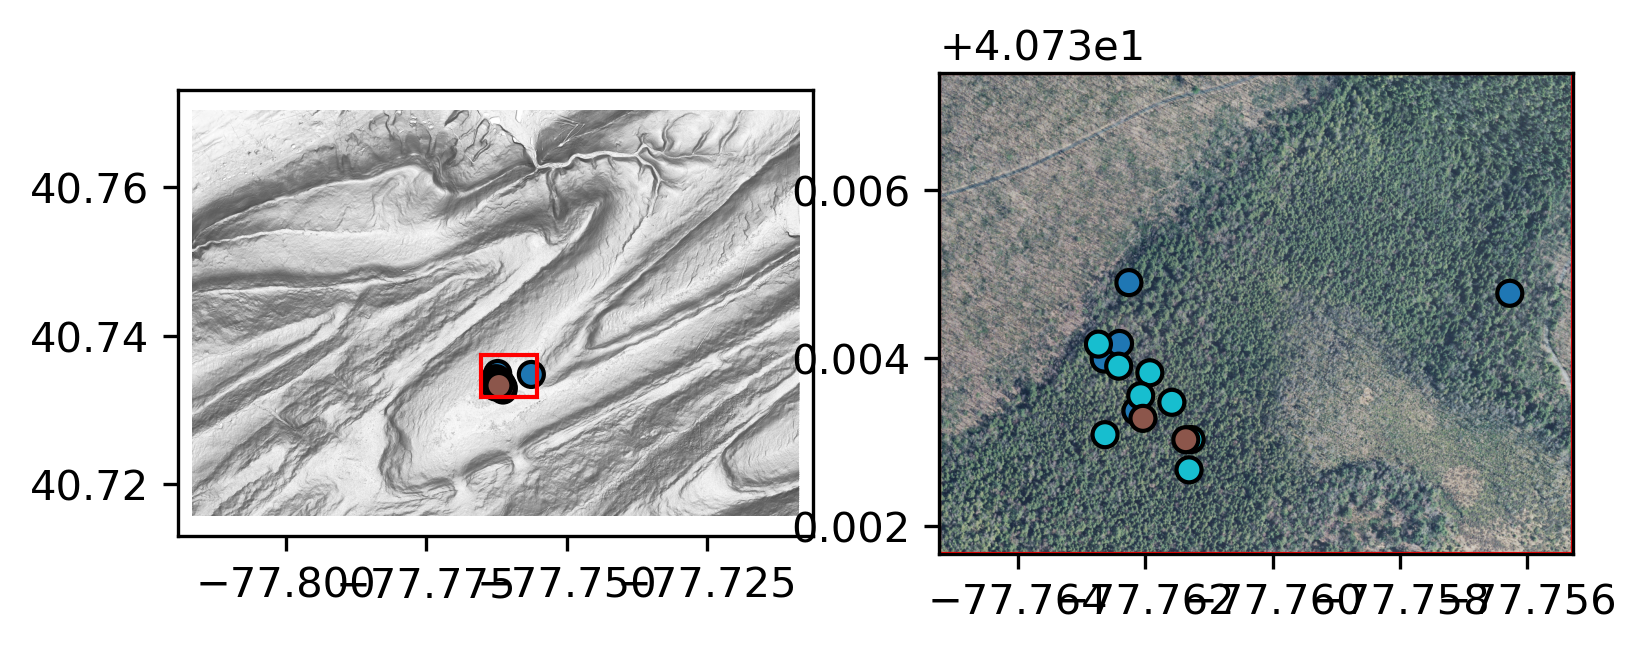

In [11]:

fig, ax = plt.subplots(1,2, dpi=300)
with rasterio.open('mosaic_slope_latlong.tif', masked=True) as slope:
    slopemap = rasterio.plot.show(slope,
                            cmap='Greys',
                            vmin=0.0, vmax=90.0,
                            ax=ax[0])
    sites = bog_sites.plot(
        edgecolors='k',
        column='Sample type',
        ax=ax[0])
    box = matplotlib.patches.Rectangle(box_params[0],
                                       width = box_params[1],
                                       height = box_params[2],
                                       edgecolor='r',
                                       facecolor='none')

    ax[0].add_patch(box)
with rasterio.open('imagery_latlong.tif', masked=True) as imagery:
    imgmap = rasterio.plot.show(imagery,
                                #extent=bog_sites_extent,
                                extent=bog_sites_box,
                                #vmin=1000.0, vmax=2500.0,
                                ax=ax[1])
    sites = bog_sites.plot(
        edgecolors='k',
        column='Sample type',
        ax=ax[1])
    box = matplotlib.patches.Rectangle(box_params[0],
                                   width = box_params[1],
                                   height = box_params[2],
                                   edgecolor='r',
                                       facecolor='none')

    ax[1].add_patch(box)

    ax[1].set_ylim(bog_sites_box[2], bog_sites_box[3])
    ax[1].set_xlim(bog_sites_box[0], bog_sites_box[1])

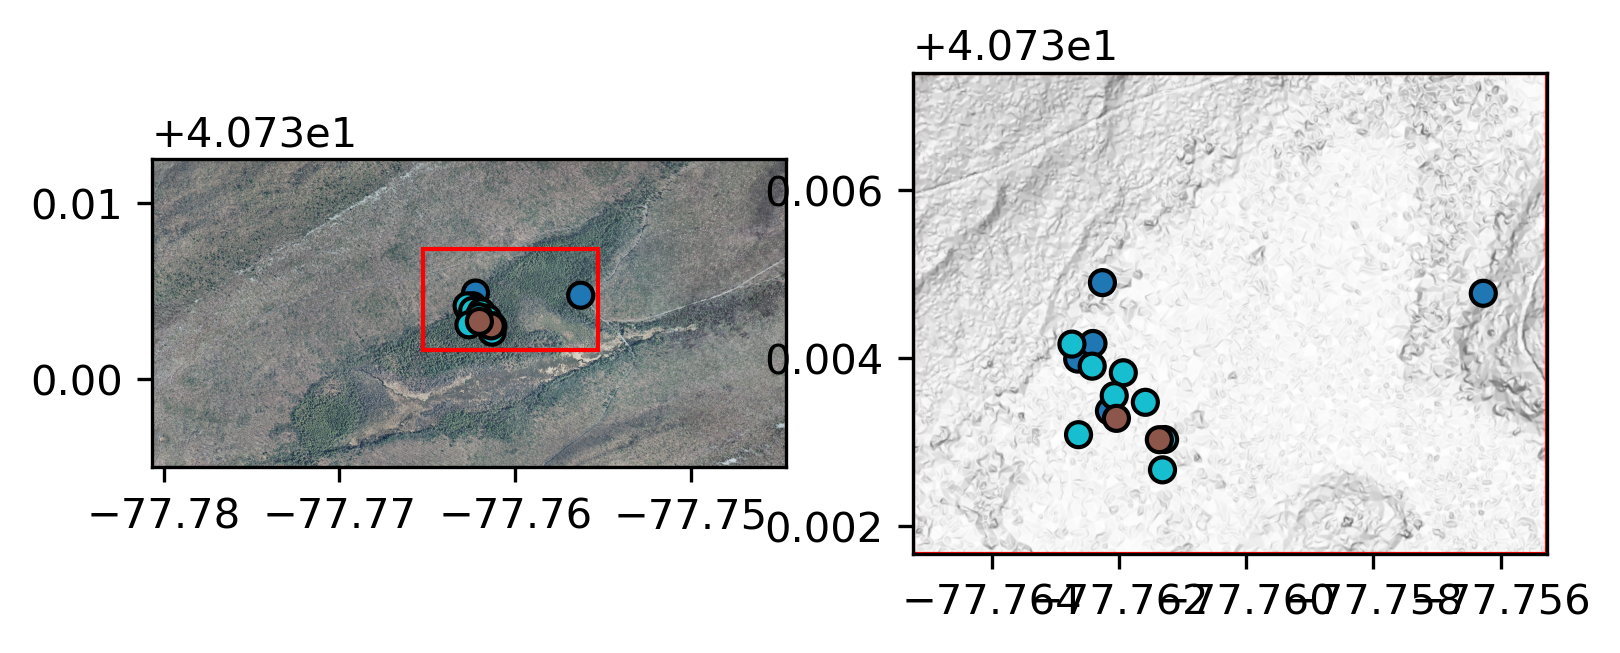

In [12]:
fig, ax = plt.subplots(1,2, dpi=300)
with rasterio.open('mosaic_slope_latlong.tif', masked=True) as slope:
    slopemap = rasterio.plot.show(slope,
                            cmap='Greys',
                            vmin=0.0, vmax=90.0,
                            ax=ax[1])
    sites = bog_sites.plot(
        edgecolors='k',
        column='Sample type',
        ax=ax[0])
    box = matplotlib.patches.Rectangle(box_params[0],
                                       width = box_params[1],
                                       height = box_params[2],
                                       edgecolor='r',
                                       facecolor='none')

    ax[0].add_patch(box)
    ax[0].set_ylim(40.725, 40.7425)
with rasterio.open('imagery_latlong.tif', masked=True) as imagery:
    imgmap = rasterio.plot.show(imagery,
                                #extent=bog_sites_extent,
                                extent=bog_sites_box,
                                #vmin=1000.0, vmax=2500.0,
                                ax=ax[0])
    sites = bog_sites.plot(
        edgecolors='k',
        column='Sample type',
        ax=ax[1])
    box = matplotlib.patches.Rectangle(box_params[0],
                                   width = box_params[1],
                                   height = box_params[2],
                                   edgecolor='r',
                                       facecolor='none')

    ax[1].add_patch(box)

    ax[1].set_ylim(bog_sites_box[2], bog_sites_box[3])
    ax[1].set_xlim(bog_sites_box[0], bog_sites_box[1])

## Stingelin core graphic

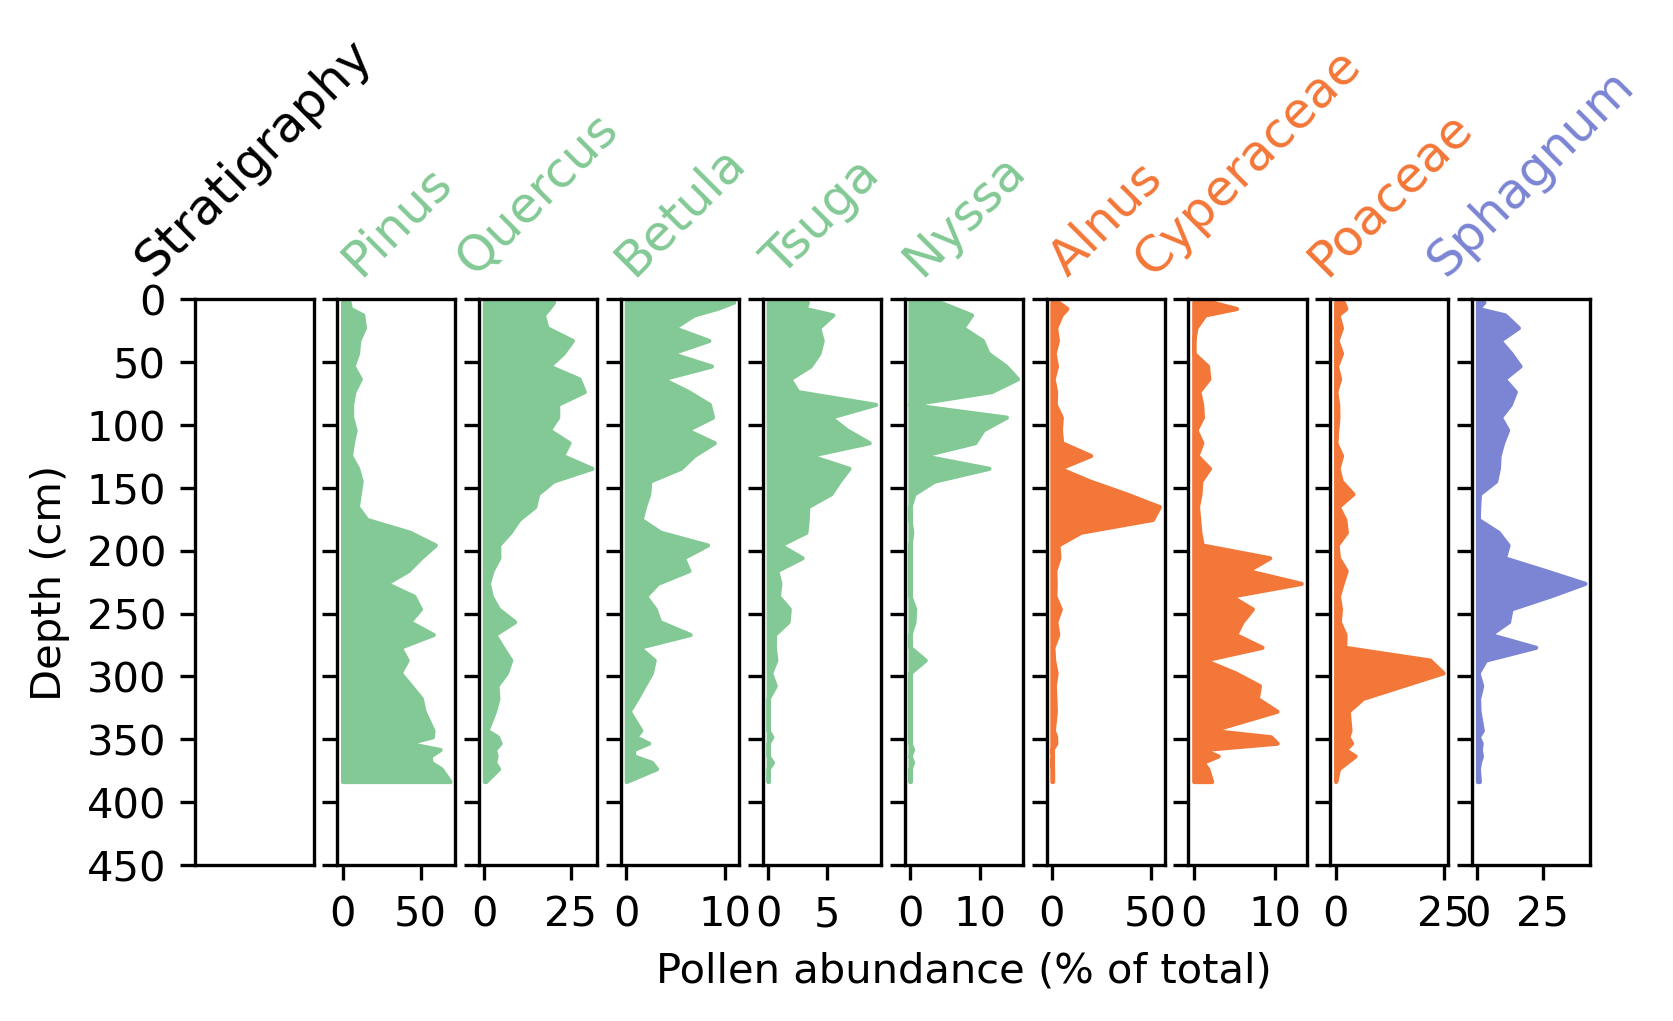

In [4]:
dfs = pd.read_csv("stingelin_correlation_new.csv")
fig, ax = plt.subplots(1,10,figsize=(6, 2.5), dpi=300, sharey=True)

ax[0].set_title('Stratigraphy', rotation=45)
ax[0].set_xticklabels('')
ax[0].tick_params(bottom=False)


ax[1].fill_betweenx( dfs['Depth'], dfs['Pinus'], color='#83c995')
ax[1].set_title('Pinus', rotation=45, color='#83c995')
ax[2].fill_betweenx(dfs['Depth'], dfs['Quercus'], color='#83c995')
ax[2].set_title('Quercus', rotation=45, color='#83c995')
ax[3].fill_betweenx(dfs['Depth'], dfs['Betula'], color='#83c995')
ax[3].set_title('Betula', rotation=45, color='#83c995')
ax[4].fill_betweenx(dfs['Depth'], dfs['Tsuga'], color='#83c995')
ax[4].set_title('Tsuga', rotation=45, color='#83c995')
ax[5].fill_betweenx(dfs['Depth'], dfs['Nyssa'], color='#83c995')
ax[5].set_title('Nyssa', rotation=45, color='#83c995')

ax[6].fill_betweenx(dfs['Depth'], dfs['Alnus'], color='#f37738')
ax[6].set_title('Alnus', rotation=45, color='#f37738')
ax[7].fill_betweenx(dfs['Depth'], dfs['Cyperaceae'], color='#f37738')
ax[7].set_title('Cyperaceae', rotation=45, color='#f37738')
ax[8].fill_betweenx( dfs['Depth'], dfs['Poaceae'], color='#f37738')
ax[8].set_title('Poaceae', rotation=45, color='#f37738')

ax[9].fill_betweenx(dfs['Depth'], dfs['Sphagnum'], color='#7b85d4')
ax[9].set_title('Sphagnum', rotation=45, color='#7b85d4')






ax[0].set_ylim(384, 0)
for y in ax:
    y.set_yticks(range(0,500,50));
    
ax[0].set_ylabel("Depth (cm)")
ax[5].set_xlabel("Pollen abundance (% of total)")

fig.savefig('Stingelin_diagram.png',bbox_inches='tight')

# XRF

## Load XRF scan and grainsize csv

In [4]:
df = pd.read_csv("Pathole2_core_log.csv")
dfg = pd.read_csv("PH2_grainsize_final.csv").dropna()

## Interpolate%grain size from percentiles

In [11]:
gs_percent = []
for sample in dfg.index:
    xcol = dfg.loc[sample,'d10':'d90']
    ycol = [10,20,30,40,50,90]
    gs_percent.append(np.interp([3.9, 62.5], xcol, ycol))
    
dfg[['%_clay', '%_silt']]=pd.DataFrame(gs_percent)

dfg['%_silt'] = dfg['%_silt'].replace(90.000000, 100)

dfg['%_silt'] = dfg['%_silt']-dfg['%_clay']

dfg['%_sand'] = 100 -(dfg['%_silt']+dfg['%_clay'])

dfg.to_csv("PH2_grainsize_interp.csv")



In [12]:
dfg_plot = dfg.replace('recore', np.nan).dropna().astype(float)

dfg_plot['%_cs'] = dfg['%_silt'] + dfg['%_clay']

## Make and save figure of raw measurements with depth 

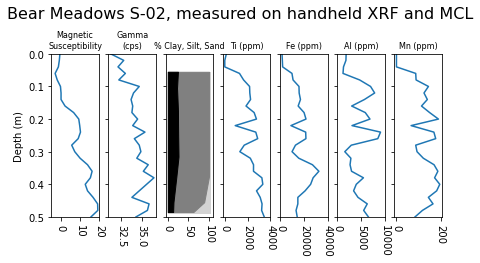

In [13]:
fig, ax = plt.subplots(1,7,figsize=(7,3),sharey=True)
# fig, ax = plt.subplots(2,4)

ax[0].plot(df['mag_sus'],df['depth_adj'])
ax[0].set_title('Magnetic\nSusceptibility',fontsize=8)
ax[0].set_ylim(0.52, 0.0)
ax[0].set_xlim(-5,20)
ax[0].set_xticks(range(0,25,10))

ax[1].plot(df['nat_gam'],df['depth_adj'])
ax[1].set_title('Gamma\n(cps)',fontsize=8)

#ax[2].plot(dfg_plot['%_clay'],(dfg_plot['depth adjusted']/100))
#ax[2].plot((dfg_plot['%_clay']+dfg_plot['%_silt']),(dfg_plot['depth adjusted']/100))
sand = matplotlib.patches.Rectangle((0,0.055),
                               width = 105,
                               height = .435,
                                   facecolor='lightgray')

ax[2].add_patch(sand)

ax[2].fill_betweenx((dfg_plot['depth adjusted']/100),dfg_plot['%_clay'], color='black', zorder=3)
ax[2].fill_betweenx((dfg_plot['depth adjusted']/100),(dfg_plot['%_cs']), color='gray', zorder=2)


ax[2].set_xticks(range(0,150,50))
ax[2].set_title('% Clay, Silt, Sand',fontsize=8)

ax[3].plot(df['Ti'],df['depth_adj'])
ax[3].set_title('Ti (ppm)',fontsize=8)
ax[3].set_xticks(range(0,6000,2000))

ax[4].plot(df['Fe'],df['depth_adj'])
ax[4].set_title('Fe (ppm)',fontsize=8)
ax[4].set_xticks(range(0,60000,20000))

ax[5].plot(df['Al'],df['depth_adj'])
ax[5].set_title('Al (ppm)',fontsize=8)
ax[5].set_xticks(range(0,15000,5000))

ax[6].plot(df['Mn'],df['depth_adj'])
ax[6].set_title('Mn (ppm)',fontsize=8)
#ax[6].set_xticks(range(900000,1000000,50000))

for x in ax:
    x.tick_params(axis='x',rotation=-90)

#fig.tight_layout()
# fig.patch.set
ax[0].set_ylabel('Depth (m)');
ax[0].set_ylim(0.50, 0.0)

plt.suptitle('Bear Meadows S-02, measured on handheld XRF and MCL', y=1.1, fontsize=16)
fig.savefig('S-02_XRF_gs_plots.pdf',bbox_inches='tight')

# Bulk organics

## Load YASIC csv

In [5]:
dfo = pd.read_csv("BMS2_YASIC_pandas.csv")
dfo_red = dfo.groupby(np.arange(len(dfo))//2).mean()
#https://stackoverflow.com/questions/36810595/calculate-average-of-every-x-rows-in-a-table-and-create-new-table
dfo_red = dfo_red.dropna()

## Make and save bulk organics figure

Text(0.5, 1.1, 'BMS-02 stable isotope geochemistry (bulk) ')

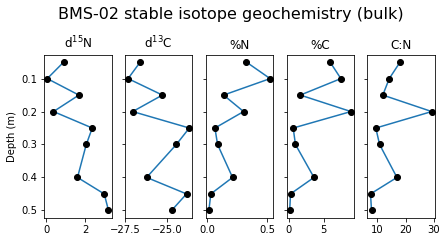

In [15]:
fig, ax = plt.subplots(1,5,figsize=(7,3),sharey=True)
# fig, ax = plt.subplots(2,4)

ax[0].plot(dfo_red['d15Nair'],dfo_red['depth_adj'])
ax[0].plot(dfo_red['d15Nair'],dfo_red['depth_adj'],'o',color='k')
ax[0].set_title('d$^{15}$N')

ax[1].plot(dfo_red['d13CVPDB'],dfo_red['depth_adj'])
ax[1].plot(dfo_red['d13CVPDB'],dfo_red['depth_adj'],'o',color='k')
ax[1].set_title('d$^{13}$C')

ax[2].plot(dfo_red['%N'],dfo_red['depth_adj'])
ax[2].plot(dfo_red['%N'],dfo_red['depth_adj'],'o',color='k')
ax[2].set_title('%N')

ax[3].plot(dfo_red['%C'],dfo_red['depth_adj'])
ax[3].plot(dfo_red['%C'],dfo_red['depth_adj'],'o',color='k')
ax[3].set_title('%C')

ax[4].plot(dfo_red['C:N'],dfo_red['depth_adj'])
ax[4].plot(dfo_red['C:N'],dfo_red['depth_adj'],'o',color='k')

ax[4].set_title('C:N')

ax[0].set_ylabel('Depth (m)')
plt.gca().invert_yaxis()

fig.suptitle('BMS-02 stable isotope geochemistry (bulk) ', y=1.1, fontsize=16)
#fig.savefig('S-02_org_plots.pdf',bbox_inches='tight')

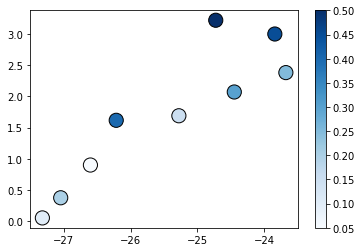

In [16]:
#Philllips 97 esque plot
plt.scatter(dfo_red['d13CVPDB'], dfo_red['d15Nair'],s=200, c=dfo_red['depth_adj'], cmap="Blues", edgecolors="k" )
plt.colorbar()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

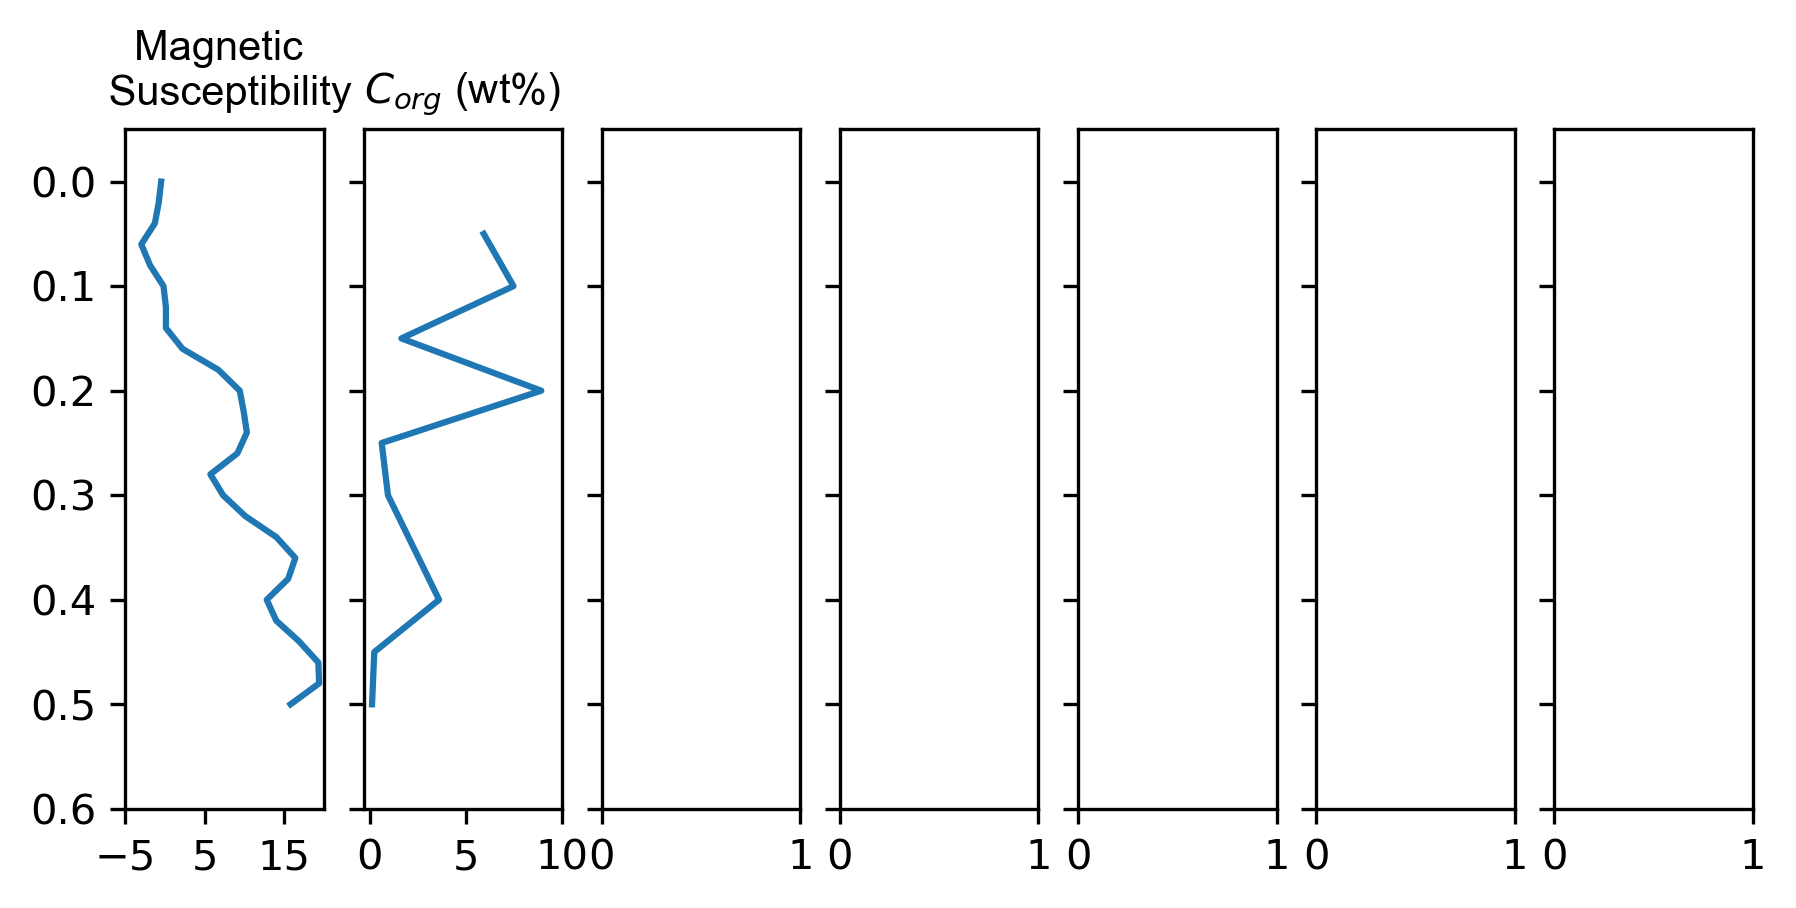

In [17]:
fig, ax = plt.subplots(1,7,figsize=(7,3),dpi=300, sharey=True)
# fig, ax = plt.subplots(2,4)

ax[0].plot(df['mag_sus'],df['depth_adj'])
ax[0].set_title('Magnetic \n Susceptibility',fontsize=10, fontname='Arial')
ax[0].set_ylim((0.6,-0.05))
ax[0].set_xlim(-5,20)
ax[0].set_xticks(range(-5,25,10))

ax[1].plot(dfo_red['%C'],dfo_red['depth_adj'])
ax[1].set_title('$C_{org}$ (wt%)',fontsize=10, fontname='Arial')
ax[1].set_xticks(range(0,11,5))

ax[2].plot(dfg['d50']-5,(dfg['depth adjusted']/100-.05))
ax[2].set_title('Median grain\n size (\u03BCm)',fontsize=10, fontname='Arial')

ax[3].plot(df['Ti'],df['depth_adj'])
ax[3].set_title('Ti (ppm)',fontsize=10, fontname='Arial')
ax[3].set_xticks(range(0,5000,3000))

ax[4].plot(df['Fe'],df['depth_adj'])
ax[4].set_title('Fe (ppm)',fontsize=10, fontname='Arial')
ax[4].set_xticks(range(0,60000,30000))

ax[5].plot(df['Al'],df['depth_adj'])
ax[5].set_title('Al (ppm)',fontsize=10, fontname='Arial')
ax[5].set_xticks(range(0,15000,10000))

ax[6].plot(df['Mn'],df['depth_adj'])
ax[6].set_title('Mn (ppm)',fontsize=10, fontname='Arial')
#ax[6].set_xticks(range(900000,1000000,50000))

#fig.tight_layout()
# fig.patch.set
ax[0].set_ylabel('Depth (m)', fontname='Arial')

plt.suptitle('Bear Meadows S-02', y=1.1, fontsize=14, fontname='Arial')
#fig.tight_layout()
fig.savefig('S-02_XRF_gs_Cor_plots.png',bbox_inches='tight')

# PCA

## Define PCA function

In [6]:
def pcaplot(variable,pca_df,coeff,per_var,colors,sym_list,s=50,labels=None):
    fig, ax = plt.subplots(figsize=(3.5,3.5),dpi=150)
    
    ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.6)
    ax.axvline(x=0, linestyle='-', linewidth=1, color='k', alpha=0.6)

    n = coeff.shape[0]
    
    coeff_scale = 7
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0]*coeff_scale, coeff[i,1]*coeff_scale, color = 'gray', alpha = 0.25)
        if labels is None:
            ax.text(coeff[i,0]* coeff_scale+0.15, coeff[i,1] * coeff_scale+0.15,
                    "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* coeff_scale, coeff[i,1] * coeff_scale,
                    labels[i], color = 'k', ha = 'center', va = 'center', fontsize=6)
    
    for i, u  in enumerate(pca_df[variable].unique()):
        df = pca_df[pca_df[variable] == u]
        col = colors.loc[df.index]
        xs = df.PC1
        ys = df.PC2
        #n = coeff.shape[0]
#         scalex = 1.0/(xs.max() - xs.min())
#         scaley = 1.0/(ys.max() - ys.min())
        scalex = scaley = 1.0
        ax.scatter(xs * scalex,ys * scaley, s=s, c = col, marker=sym_list[i],alpha=.75,edgecolors='k',label=u)
    

#     ax.set_xlim(-.6,.6)
#     ax.set_ylim(-.6,.6)
    ax.set_xlabel("PC1 - {0}%".format(per_var[0]))
    ax.set_ylabel("PC2 - {0}%".format(per_var[1]))
    ax.grid(ls='--')
    ax.set_axisbelow(True)

#     legend_elements = [Line2D([0],[0],marker='o',lw=0,color=c_list[i],label=str(cluster_list[i]),
#                          markerfacecolor=c_list[i],markersize=5) for i in range(0,len(lut))]
#     ax.legend(handles=legend_elements,loc='lower center', bbox_to_anchor=(1.5, -0.05), fontsize=8)

    ax.legend()
    return fig, ax

## Load in csv with hillslope samples and elements and isolate heavy elements and high thresholds

In [7]:
heavy_elements = ['Ti', 'Zr', 'Mn', 'Fe', 'V', 'Cr', 'Ni', 'Cu', 'Zn', 'As', 'Ag', 'Cd',
       'Sn', 'Sb', 'Pb', 'Bi']
hi_threshold_elements = ['Ti', 'Zr', 'Mn', 'Fe', 'V', 'Cr', 'Zn', 'Ag', 'Cd', 'Sn', 'Sb', 'Pb',
       'LE', 'Al', 'Si', 'K', 'Ca']

In [8]:
df2 = pd.read_csv("hs_core_cleaned.csv")
#df2 = pd.read_csv("hillslope_samples.csv")

hs_cols = []

hs_data = df2.iloc[:, 8:] #heavies and lights

hs_data = hs_data.dropna(axis=1)
hs_data.columns

Index(['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'As', 'Zr', 'Ag', 'Cd',
       'Sn', 'Sb', 'Pb', 'Bi', 'LE', 'Mg', 'Al', 'Si', 'P', 'K', 'Ca'],
      dtype='object')

## Make a new PCA with hillslope and bog data

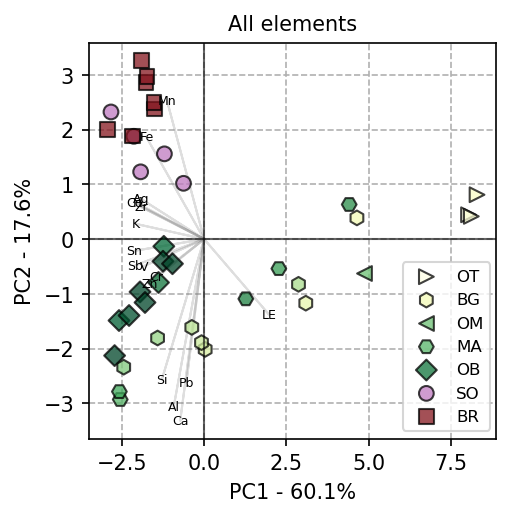

In [9]:

hs_data = hs_data[hi_threshold_elements]

scaled_data = preprocessing.scale(hs_data)

# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)
# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# the loading scores are the proportions that make up the PCs
loading_scores1 = pd.Series(pca.components_[0], index=hs_data.columns)
loading_scores2 = pd.Series(pca.components_[1], index=hs_data.columns)
loading_scores3 = pd.Series(pca.components_[2], index=hs_data.columns)
loading_scores = pd.concat([loading_scores1,loading_scores2,loading_scores3],axis=1)

sorted_loading_scores1 = loading_scores1.abs().sort_values(ascending=False)
sorted_loading_scores2 = loading_scores2.abs().sort_values(ascending=False)
top_10_1 = sorted_loading_scores1[0:].index.values
loading_scores1[top_10_1];

pca_df = pd.DataFrame(pca_data, index=hs_data.index,columns=labels)
pca_df = pd.merge(pca_df,df2['unit_desc'],left_index=True, right_index=True)

cluster_list = df2['depth_adj'].unique()
# set colormap
low = 0
high = 1.25
number_of_lines= len(cluster_list)
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap("YlGn")
c_list = [ cmap(x) for x in cm_subsection ]
c_list[:-1]
lut = dict(zip(cluster_list, c_list))
colors = df2['depth_adj'].map(lut)

colors[df2.index[df2['unit_desc']=='SO']]='#BF7AC1'

colors[df2.index[df2['unit_desc']=='BR']]='#84151E'


sym_list = ['>','h','<','H','D','o','s']
sut = dict(zip(df2['unit_desc'].unique(), sym_list))
symbols = df2['unit_desc'].map(sut)


coeff = np.transpose(pca.components_[[0,1], :]) # take the first two PCs
fig, ax = pcaplot('unit_desc',pca_df, coeff=coeff, per_var=per_var,
                  colors=colors,sym_list=sym_list,labels=loading_scores.index)
ax.legend(loc='lower center', bbox_to_anchor=(.88, 0), fontsize=8)

ax.set_title('All elements',fontsize=10)

agePCA_all_elements = pd.merge(df, pca_df,left_index=True,right_index=True)

In [10]:
loading = pd.DataFrame(data=loading_scores.values, index=loading_scores.index, columns=['PC1','PC2','PC3'])
loading.to_csv('loading_scores_all_elements.csv',index=True)

In [11]:
fig.savefig('all_elements.svg', dpi=300)

## Same thing but with heavy elements only

Text(0.5, 1.0, 'Metals and heavy elements')

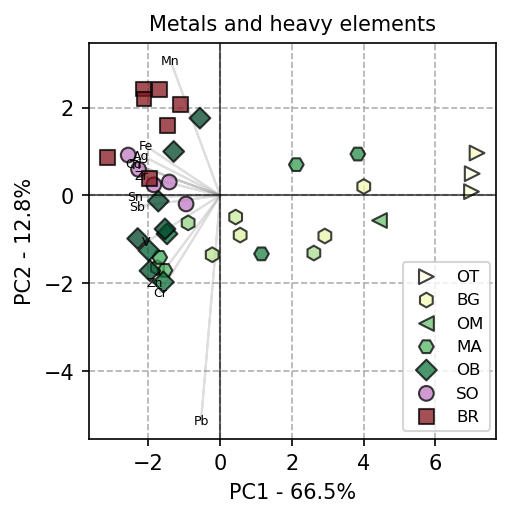

In [12]:
hs_data = df2[list(set(heavy_elements) & set(hi_threshold_elements))]


scaled_data = preprocessing.scale(hs_data)

# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)
# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# the loading scores are the proportions that make up the PCs
loading_scores1 = pd.Series(pca.components_[0], index=hs_data.columns)
loading_scores2 = pd.Series(pca.components_[1], index=hs_data.columns)
loading_scores3 = pd.Series(pca.components_[2], index=hs_data.columns)
loading_scores = pd.concat([loading_scores1,loading_scores2,loading_scores3],axis=1)

sorted_loading_scores1 = loading_scores1.abs().sort_values(ascending=False)
top_10_1 = sorted_loading_scores1[0:].index.values
loading_scores1[top_10_1];

pca_df = pd.DataFrame(pca_data, index=hs_data.index,columns=labels)
pca_df = pd.merge(pca_df,df2['unit_desc'],left_index=True, right_index=True)

cluster_list = df2['depth_adj'].unique()
# set colormap
low = 0
high = 1.25
number_of_lines= len(cluster_list)
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap("YlGn")
c_list = [ cmap(x) for x in cm_subsection ]
c_list[:-1]
lut = dict(zip(cluster_list, c_list))
colors = df2['depth_adj'].map(lut)

colors[df2.index[df2['unit_desc']=='SO']]='#BF7AC1'

colors[df2.index[df2['unit_desc']=='BR']]='#84151E'


sym_list = ['>','h','<','H','D','o','s']
sut = dict(zip(df2['unit_desc'].unique(), sym_list))
symbols = df2['unit_desc'].map(sut)


coeff = np.transpose(pca.components_[[0,1], :]) # take the first two PCs
fig, ax = pcaplot('unit_desc',pca_df, coeff=coeff, per_var=per_var,
                  colors=colors,sym_list=sym_list,labels=loading_scores.index)
ax.legend(loc='lower center', bbox_to_anchor=(.88, 0), fontsize=8)

ax.set_title('Metals and heavy elements',fontsize=10)

In [13]:
loading = pd.DataFrame(data=loading_scores.values, index=loading_scores.index, columns=['PC1','PC2','PC3'])
loading.to_csv('loading_scores_heavy_elements.csv',index=True)

In [14]:
fig.savefig('heavy_elements.svg', dpi=300)

In [15]:
# Get the agePCA dataset for the time series plot

agePCA = pd.merge(df,pca_df,left_index=True,right_index=True)

## Simple plot for presentations

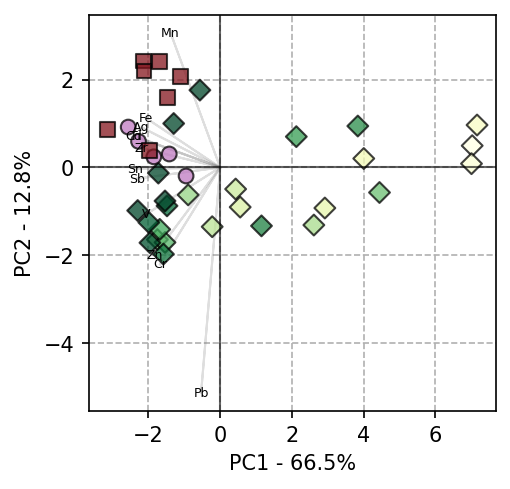

In [16]:
hs_data = df2[list(set(heavy_elements) & set(hi_threshold_elements))]


scaled_data = preprocessing.scale(hs_data)

# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)
# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# the loading scores are the proportions that make up the PCs
loading_scores1 = pd.Series(pca.components_[0], index=hs_data.columns)
loading_scores2 = pd.Series(pca.components_[1], index=hs_data.columns)
loading_scores3 = pd.Series(pca.components_[2], index=hs_data.columns)
loading_scores = pd.concat([loading_scores1,loading_scores2,loading_scores3],axis=1)

sorted_loading_scores1 = loading_scores1.abs().sort_values(ascending=False)
top_10_1 = sorted_loading_scores1[0:].index.values
loading_scores1[top_10_1];

pca_df = pd.DataFrame(pca_data, index=hs_data.index,columns=labels)
pca_df = pd.merge(pca_df,df2['unit_desc'],left_index=True, right_index=True)

cluster_list = df2['depth_adj'].unique()
# set colormap
low = 0
high = 1.25
number_of_lines= len(cluster_list)
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap("YlGn")
c_list = [ cmap(x) for x in cm_subsection ]
c_list[:-1]
lut = dict(zip(cluster_list, c_list))
colors = df2['depth_adj'].map(lut)

colors[df2.index[df2['unit_desc']=='SO']]='#BF7AC1'

colors[df2.index[df2['unit_desc']=='BR']]='#84151E'


sym_list = ['D','D','D','D','D','o','s']
sut = dict(zip(df2['unit_desc'].unique(), sym_list))
symbols = df2['unit_desc'].map(sut)


coeff = np.transpose(pca.components_[[0,1], :]) # take the first two PCs
fig, ax = pcaplot('unit_desc',pca_df, coeff=coeff, per_var=per_var,
                  colors=colors,sym_list=sym_list,labels=loading_scores.index)
ax.get_legend().remove()



# Time series

## Load all databases, clean data

In [17]:
dfs = pd.read_csv("stingelin_correlation_new.csv")
dfo = pd.read_csv("oxygen.csv")
dfb = pd.read_csv("bacon_ages3.csv")
dfd = pd.read_csv("NGRIP_dust.csv")
dfr = pd.read_csv("radiocarbon.csv")

In [18]:
# Calculate accumulation rate
dfb_accum = np.zeros(len(dfb['depth']))

for x in range (0, len(dfb['depth'])-1):
    dfb_accum[x] = (dfb['depth'][x+1]-dfb['depth'][x])/(dfb['mean'][x+1]-dfb['mean'][x])
    
dfb_accum[-1] = np.nan

In [30]:
# Limit NGRIP data to the time intervals in which you are interested
o18_sub_age = dfo['Age'][0::2]
o18_sub_ox = dfo['d18O'][0::2]

## Make and save time series figures

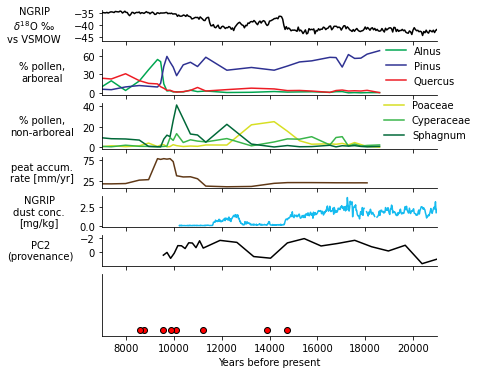

In [31]:
fig, ax = plt.subplots(7,1,figsize=(6,6),sharex=True, frameon=False, gridspec_kw={'height_ratios':[1,1.5,1.5,1,1,1,2]})
# fig, ax = plt.subplots(2,4)

ax[0].plot(o18_sub_age, o18_sub_ox, color='k')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
#ax[0].spines['bottom'].set_visible(False)
# ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax[0].set_ylabel('NGRIP\n$\delta^{18}$O ‰\nvs VSMOW', rotation=0, labelpad=40, va='center')


#ax[1].plot(dfs['mean age'],(dfs['Abies']+dfs['Picea']),label='Abies+Picea')
ax[1].plot(dfs['Age 3'],(dfs['Alnus']), label='Alnus', color='#00A651')
ax[1].plot(dfs['Age 3'],(dfs['Pinus']), label='Pinus', color='#2E3192')
ax[1].plot(dfs['Age 3'],(dfs['Quercus']), label = 'Quercus', color='#ED1C24')
#ax[1].plot(dfs['mean age'],(dfs['Tsuga']))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_yticks([0,30,60])
#ax[1].spines['bottom'].set_visible(False)
ax[1].legend()
ax[1].set_ylabel('% pollen,\narboreal', rotation=0, labelpad=40, va='center')
ax[1].legend(loc='lower center', bbox_to_anchor=(.95, 0), frameon=False)
# h, l = ax[1].get_legend_handles_labels()
#ax[1].legend(labels = [l])

ax[2].plot(dfs['Age 3'],(dfs['Poaceae']), label='Poaceae', color='#D7DF23')
ax[2].plot(dfs['Age 3'],(dfs['Cyperaceae']), label='Cyperaceae', color='#39B54A')
ax[2].plot(dfs['Age 3'],(dfs['Sphagnum']), label='Sphagnum', color='#006838')
ax[2].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_yticks([0,20,40])
ax[2].legend(loc='lower center', bbox_to_anchor=(.972, 0), frameon=False)
#ax[2].spines['bottom'].set_visible(False)

# ax[3].plot(dfs['mean age'],(dfs['Sphagnum']))
# ax[3].spines['top'].set_visible(False)
# ax[3].spines['right'].set_visible(False)
# #ax[3].spines['bottom'].set_visible(False)

ax[3].plot(dfb['mean'], dfb_accum*1000, color='#603917')
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
#ax[3].spines['bottom'].set_visible(False)
# ax[3].legend(['acc rate, Stingelin'], bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax[3].set_ylabel('peat accum.\nrate [mm/yr]', rotation=0, labelpad=40, va='center')
ax[3].set_yticks([25,75])

ax[4].plot(dfd['age_ka'], dfd['Dust conc [microg/kg]']*0.001, color='#16BBEF', label='Greenland ice dust concentration')
ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].set_ylabel('NGRIP\ndust conc.\n[mg/kg]', rotation=0, labelpad=40, va='center')

# ax[5].spines['top'].set_visible(False)
# ax[5].spines['right'].set_visible(False)
# ax[5].plot(agePCA.age_extrapolated, agePCA.PC1, 'g')
# ax[5].set_ylabel('PC1\n(organics)')
ax[5].plot(agePCA.age_extrapolated, agePCA.PC2, 'k')
ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].set_ylabel('PC2\n(provenance)',rotation=0, labelpad=40, va='center')
ax[5].set_yticks([0,-2.0])
ax[5].set_ylim((2.1,-2.5))
# ax[5].hlines(pca_df['PC2'][pca_df['unit_desc']=='SO'].mean(), xmin=9500, xmax=21500, color='#BF7AC1')
# ax[5].hlines(pca_df['PC2'][pca_df['unit_desc']=='BR'].mean(), xmin=9500, xmax=21500, color='#84151E')
# ax[5].hlines(-2, xmin=9500, xmax=21500, color='#16BBEF')
# ax[5].yaxis.label.set_color('g')
# ax[5].tick_params(axis='y', colors='g')
# ax[5].spines['left'].set_color('g')

# ax[5].spines['top'].set_visible(False)
# ax[5].spines['right'].set_visible(False)
# ax[5].plot(agePCA.age_extrapolated, agePCA.PC1, 'g')
# ax[5].set_ylabel('PC1\n(organics)')
# ax2 = ax[5].twinx()
# ax2.plot(agePCA.age_extrapolated, agePCA.PC2, 'k')
# ax2.spines['top'].set_visible(False)
# ax2.set_ylabel('PC2\n(provenance)')
# ax[5].yaxis.label.set_color('g')
# ax[5].tick_params(axis='y', colors='g')
# ax[5].spines['left'].set_color('g')


ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].plot(dfr['Cal ka'], np.zeros(len(dfr['Cal ka'])), 'ro', mec='k')
ax[6].yaxis.set_visible(False)
# ax[6].set_yticklabels([])
# ax[6].set_yticks([])
# ax[6].set_ylabel('bog center\n\n\n\nbog edge',rotation=0, labelpad=40, va='center')
ax[6].set_ylim([-.1,1])

ax[0].set_xlim(7000,21000)
ax[6].set_xlabel('Years before present')
#ax[0].set_xticks(range(6000,22000,2000))

# fig.tight_layout()

fig.savefig('bog_time_data_new.svg', dpi=300)

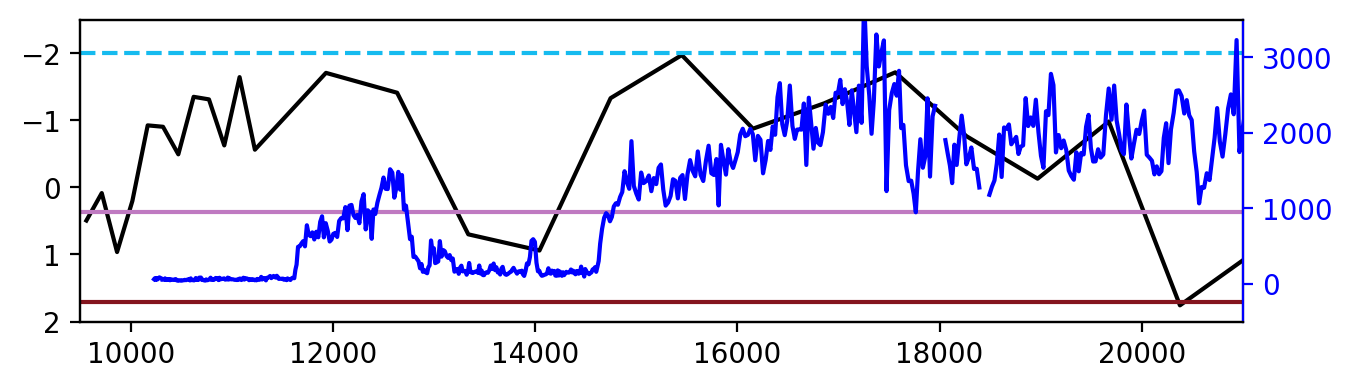

In [32]:
fig, ax = plt.subplots(figsize=(7.5,2),dpi=200)
ax.plot(agePCA.age_extrapolated, agePCA.PC2, 'k')
ax.hlines(pca_df['PC2'][pca_df['unit_desc']=='SO'].mean(), xmin=9500, xmax=21500, color='#BF7AC1')
ax.hlines(pca_df['PC2'][pca_df['unit_desc']=='BR'].mean(), xmin=9500, xmax=21500, color='#84151E')
ax.hlines(-2, xmin=9500, xmax=21500, color='#16BBEF', ls='--')

ax2 = ax.twinx()
ax2.plot(dfd['age_ka'], dfd['Dust conc [microg/kg]'], color='blue')
ax2.set_ylim((-500,3500))


ax.set_xlim(9500,21000)
ax.set_ylim((2,-2.5))



ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.spines['right'].set_color('blue')

(2.1, -2.5)

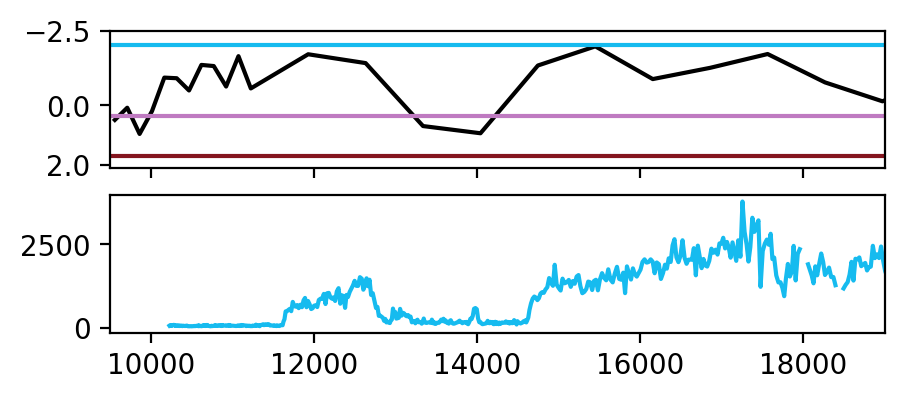

In [33]:
fig, ax = plt.subplots(2,1,figsize=(5,2),dpi=200, sharex=True)
ax[0].plot(agePCA.age_extrapolated, agePCA.PC2, 'k')
ax[0].hlines(pca_df['PC2'][pca_df['unit_desc']=='SO'].mean(), xmin=9500, xmax=21500, color='#BF7AC1')
ax[0].hlines(pca_df['PC2'][pca_df['unit_desc']=='BR'].mean(), xmin=9500, xmax=21500, color='#84151E')
ax[0].hlines(-2, xmin=9500, xmax=21500, color='#16BBEF')


ax[1].plot(dfd['age_ka'], dfd['Dust conc [microg/kg]'], color='#16BBEF')


ax[0].set_yticks([2,0,-2.5])
ax[0].set_xlim(9500,19000)
ax[0].set_ylim((2.1,-2.5))

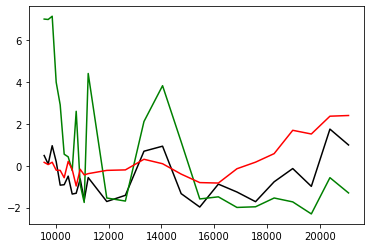

In [34]:
fig, ax = plt.subplots()
ax.plot(agePCA.age_extrapolated, agePCA.PC2, 'k')
ax.plot(agePCA.age_extrapolated, agePCA.PC1, 'g')
ax.plot(agePCA.age_extrapolated, agePCA.PC3, 'r')

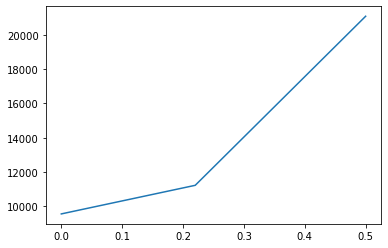

In [35]:
plt.plot(agePCA.depth_adj, agePCA.age_extrapolated)

In [36]:
import matplotlib
print(matplotlib.__version__)

3.5.1


In [19]:
pd.to_numeric(df["depth_adj"])
result0=df[['depth_adj','age_extrapolated']]
result=dfo_red.merge(result0,how='left',left_on='depth_adj', right_on='depth_adj')
result=result.interpolate(method='linear',limit_direction='backward')

In [20]:
result

depth_adj   weight   d15Nair   d13CVPDB        %N        %C        C:N  \
0       0.05  30.2140  0.900642 -26.601201  0.329529  5.930818  17.998757   
1       0.10  25.6790  0.055063 -27.320688  0.526953  7.477002  14.189902   
2       0.15  31.4340  1.688215 -25.276704  0.138646  1.651947  11.915659   
3       0.20  26.2520  0.377093 -27.046154  0.305603  8.920157  29.186777   
4       0.25  33.2255  2.378280 -23.674564  0.066535  0.628627   9.448081   
5       0.30  32.8355  2.068251 -24.446885  0.088588  0.954389  10.773241   
6       0.40  27.3930  1.615709 -26.214782  0.213537  3.609542  16.903300   
7       0.45  50.8210  2.995338 -23.839802  0.032101  0.243211   7.576453   
8       0.50  49.9125  3.215358 -24.724527  0.016131  0.127829   7.924912   

   age_extrapolated  
0          10318.00  
1          10318.00  
2          10696.75  
3          11075.50  
4          12558.75  
5          14042.00  
6          17562.00  
7          19322.00  
8          21082.00

In [34]:
agePCA[['depth_adj','age_extrapolated']]

depth_adj  age_extrapolated
0        0.00            9560.0
1        0.02            9712.0
2        0.04            9863.5
3        0.06           10015.0
4        0.08           10166.5
5        0.10           10318.0
6        0.12           10469.5
7        0.14           10621.0
8        0.16           10772.5
9        0.18           10924.0
10       0.20           11075.5
11       0.22           11227.0
12       0.24           11930.0
13       0.26           12634.0
14       0.28           13338.0
15       0.30           14042.0
16       0.32           14746.0
17       0.34           15450.0
18       0.36           16154.0
19       0.38           16858.0
20       0.40           17562.0
21       0.42           18266.0
22       0.44           18970.0
23       0.46           19674.0
24       0.48           20378.0
25       0.50           21082.0

In [46]:
[float(i.get_text()) for i in ax2.get_yticklabels()]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [79]:
result.loc[result['depth_adj'] > 0.25,'depth_adj']

5    0.30
6    0.40
7    0.45
8    0.50
Name: depth_adj, dtype: float64

In [80]:
result

depth_adj   weight   d15Nair   d13CVPDB        %N        %C        C:N  \
0       0.05  30.2140  0.900642 -26.601201  0.329529  5.930818  17.998757   
1       0.10  25.6790  0.055063 -27.320688  0.526953  7.477002  14.189902   
2       0.15  31.4340  1.688215 -25.276704  0.138646  1.651947  11.915659   
3       0.20  26.2520  0.377093 -27.046154  0.305603  8.920157  29.186777   
4       0.25  33.2255  2.378280 -23.674564  0.066535  0.628627   9.448081   
5       0.30  32.8355  2.068251 -24.446885  0.088588  0.954389  10.773241   
6       0.40  27.3930  1.615709 -26.214782  0.213537  3.609542  16.903300   
7       0.45  50.8210  2.995338 -23.839802  0.032101  0.243211   7.576453   
8       0.50  49.9125  3.215358 -24.724527  0.016131  0.127829   7.924912   

   age_extrapolated  
0          10318.00  
1          10318.00  
2          10696.75  
3          11075.50  
4          12558.75  
5          14042.00  
6          17562.00  
7          19322.00  
8          21082.00

C:\Users\f005dv1\AppData\Local\Temp\ipykernel_11908\4205742951.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(age_labels);


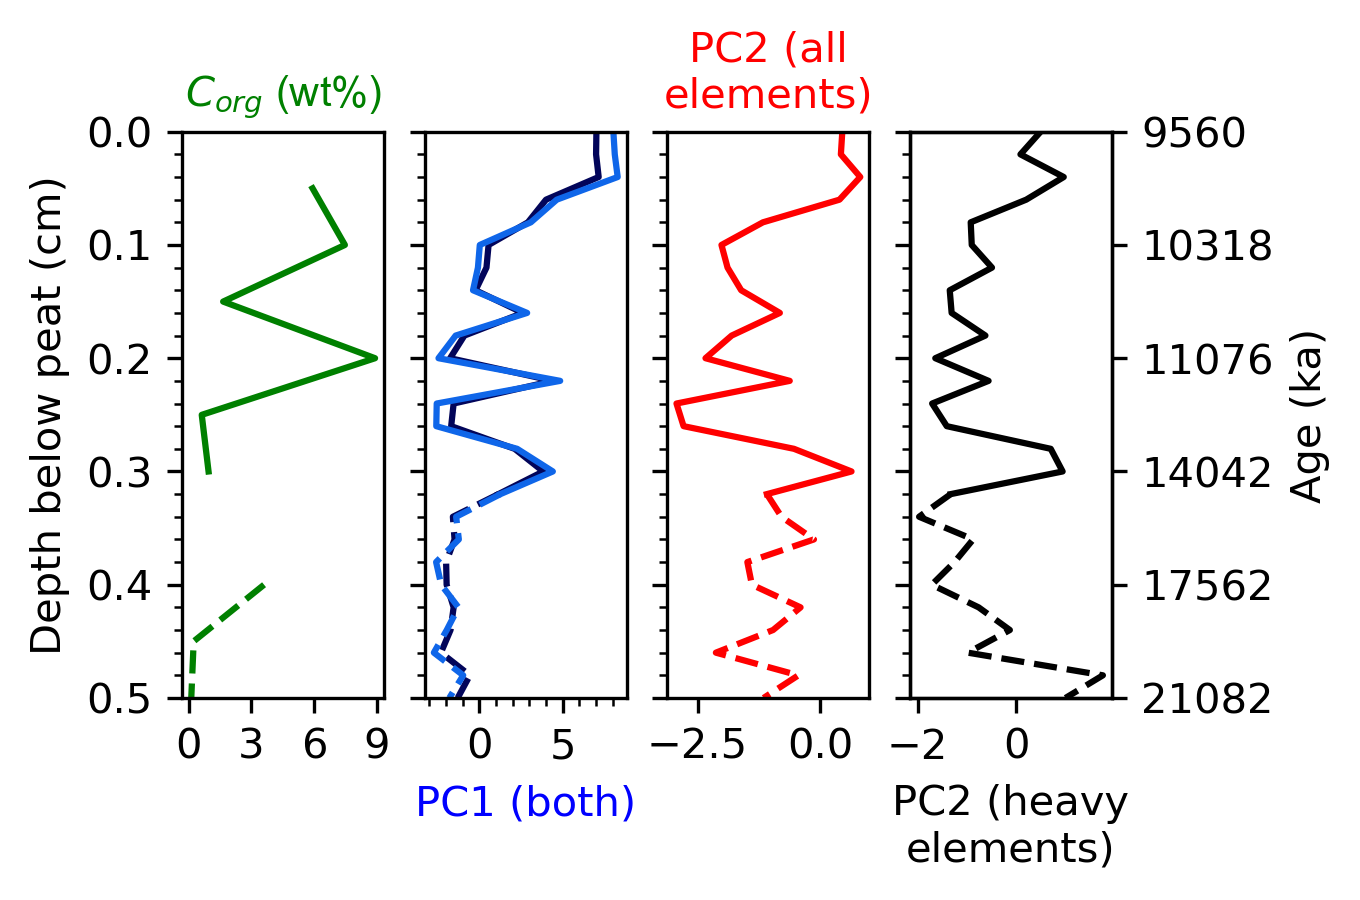

In [90]:
fig, ax = plt.subplots(1,4, figsize=(4, 2.5), dpi=300, sharey=True)


#, np.arange(0, agePCA.depth_adj.max(), .05)
# ax2.set_ylim(0.0, agePCA.age_extrapolated.max())
#ax2.set_ylim(agePCA.age_extrapolated.max(), agePCA.age_extrapolated.min())


ax[0].plot(result.loc[result['depth_adj'] <= 0.30,'%C'],
           result.loc[result['depth_adj'] <= 0.30,'depth_adj'],
           'g', label='$C_{org}$\n(wt%)')
ax[0].plot(result.loc[result['depth_adj'] > 0.30,'%C'],
           result.loc[result['depth_adj'] > 0.30,'depth_adj'],
           'g--', label='$C_{org}$\n(wt%)')
ax[0].set_xticks(np.arange(0.0, 12.0, 3))
ax[0].set_title('$C_{org}$ (wt%)',fontsize=10, color='g',fontname='Arial')
ax[0].set_ylim(0.5, 0.0)
ax[0].set_ylabel("Depth below peat (cm)")



ax[1].plot(agePCA.loc[agePCA['depth_adj'] <= 0.32, 'PC1'],
           agePCA.loc[agePCA['depth_adj'] <= 0.32, 'depth_adj'], c='#02055a', label='PC1')
ax[1].plot(agePCA.loc[agePCA['depth_adj'] > 0.3, 'PC1'],
           agePCA.loc[agePCA['depth_adj'] > 0.3, 'depth_adj'], c='#02055a', ls='--', label='PC1')

ax[1].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'PC1'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'depth_adj'], c='#0f66e9', label='PC1')
ax[1].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'PC1'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'depth_adj'], c='#0f66e9', ls='--', label='PC1')

#ax[1].plot( agePCA_all_elements.PC1, agePCA.depth_adj,'#0f66e9', label='PC1')
ax[1].set_xlabel("PC1 (both)", color='b')
ax[1].minorticks_on()


ax[2].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'PC2'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'depth_adj'], c='r', label='PC2')
ax[2].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'PC2'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'depth_adj'], c='r', ls='--', label='PC2')
ax[2].set_title("PC2 (all\nelements)", color='r', fontsize=10)


ax[3].plot(agePCA.loc[agePCA['depth_adj'] <= 0.32, 'PC2'],
           agePCA.loc[agePCA['depth_adj'] <= 0.32, 'depth_adj'], c='k', label='PC2')
ax[3].plot(agePCA.loc[agePCA['depth_adj'] > 0.3, 'PC2'],
           agePCA.loc[agePCA['depth_adj'] > 0.3, 'depth_adj'], c='k', ls='--', label='PC2')


ax[3].set_xlabel("PC2 (heavy\nelements)")

ax2 = ax[3].twinx()

ax2.plot(agePCA.PC2, agePCA.depth_adj, alpha=0.0)
ax2.set_ylim(0.5, 0.0)
ax2.set_ylabel("Age (ka)")

# ticklist = [float(i.get_text()) for i in ax2.get_yticklabels()]
# For some reason this doesn't work in this block but will outside this block...
ticklist = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# So this is the cheesy fix
age_labels = [f'{int(round(i,0))}' for i in agePCA.loc[agePCA.depth_adj.isin(ticklist), 'age_extrapolated'].values]
ax2.set_yticklabels(age_labels);
# Slices where detphs are equal to ticklist, labels them with the corresponding extrapolated age. 
# And also print formatted to the nearest whole number

#ax[0].set_ylim(agePCA.depth_adj.max(), agePCA.depth_adj.min())
fig.savefig('PCs_depth_time.png', dpi=300, bbox_inches='tight')

C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


Text(0.5, 1.0, 'All elements')

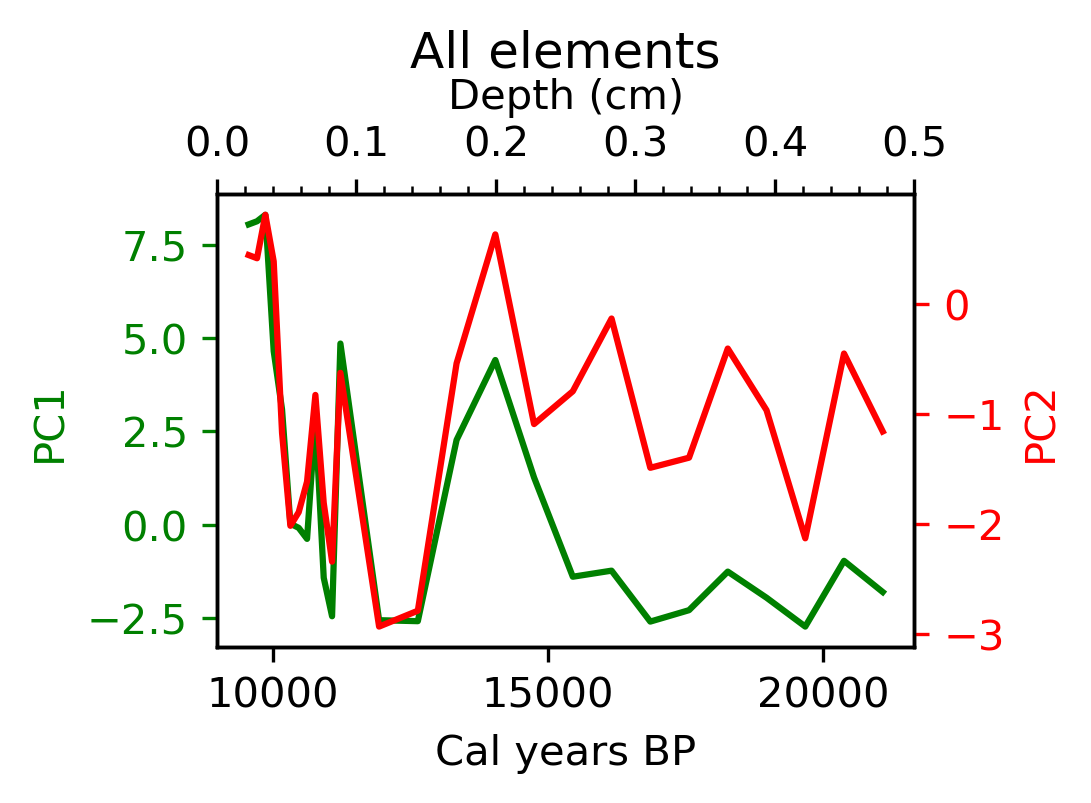

In [340]:
fig, ax0 = plt.subplots(figsize=(3,2),dpi=300, sharex=True)

ax1 = ax0.twinx()

ax0.plot(agePCA.age_extrapolated, agePCA_all_elements.PC1, 'g')
ax1.plot(agePCA.age_extrapolated, agePCA_all_elements.PC2, 'r')



ax1.yaxis.label.set_color('red')
ax1.set_ylabel("PC2")
ax1.tick_params(axis='y', colors='red')

ax0.yaxis.label.set_color('green')
ax0.tick_params(axis='y', colors='green')
ax0.set_ylabel("PC1")
ax0.set_xlabel("Cal years BP")

ax2 = ax0.twiny()
ax2.set_xticks(agePCA.depth_adj, [0.0, agePCA.depth_adj.max()])
#, np.arange(0, agePCA.depth_adj.max(), .05)
ax2.set_xlim(0.0, agePCA.depth_adj.max())
ax2.set_xlabel("Depth (cm)")
#ax2.set_xlim(ax0.get_xlim())

plt.title('All elements', pad=-100)
#plt.savefig("all_element_pca_ages.svg", bbox_inches='tight')

#https://stackoverflow.com/questions/12919230/how-to-share-secondary-y-axis-between-subplots-in-matplotlib

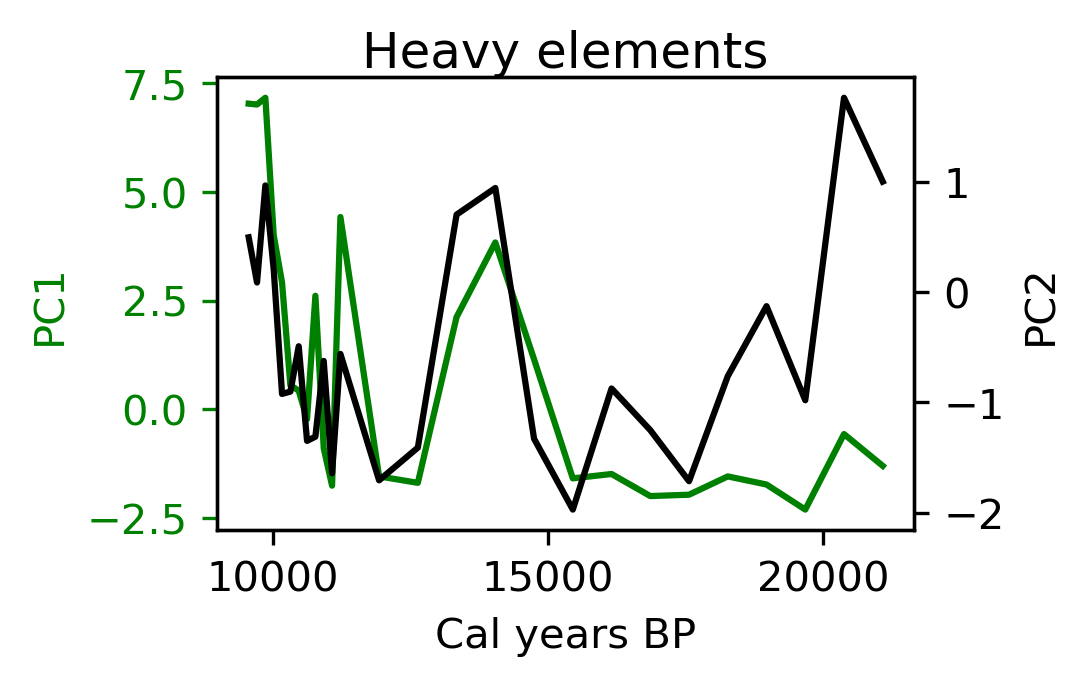

In [333]:
fig, ax0 = plt.subplots(figsize=(3,2),dpi=300, sharex=True)

ax1 = ax0.twinx()

ax0.plot(agePCA.age_extrapolated, agePCA.PC1, 'g')
ax1.plot(agePCA.age_extrapolated, agePCA.PC2, 'k')

ax0.set_title('Heavy elements', pad=-100)

ax1.yaxis.label.set_color('k')
ax1.set_ylabel("PC2")
ax1.tick_params(axis='y', colors='k')

ax0.yaxis.label.set_color('green')
ax0.tick_params(axis='y', colors='green')
ax0.set_ylabel("PC1")
ax0.set_xlabel("Cal years BP")



plt.savefig("heavy_element_pca_ages.svg")

#https://stackoverflow.com/questions/12919230/how-to-share-secondary-y-axis-between-subplots-in-matplotlib

# Neotoma pollen plots

In [40]:
bigpond = pd.read_csv("bigpond_pct.csv", encoding='latin-1')
browns = pd.read_csv("browns_pct.csv", encoding='latin-1')
cranb = pd.read_csv("cranb_pct.csv", encoding='latin-1')
crider = pd.read_csv("crider_pct.csv", encoding='latin-1')
hack = pd.read_csv("hack_pct.csv", encoding='latin-1')
panther = pd.read_csv("panther_pct.csv", encoding='latin-1')
potts = pd.read_csv("potts_pct.csv", encoding='latin-1')

dfs['median']=dfs['Age 3']

sitelist = [dfs, bigpond, browns, cranb, crider, hack, panther, potts]
sitenamelist = ['Bear Meadows', 'Big Pond', 'Browns Pond', 'Cranberry Glades', 'Criders Pond',
                'Hack Pond', 'Panther Run Pond', 'Potts Mountain Pond']

In [41]:
for frame in sitelist:
    Alnus_cols = [col for col in frame.columns if 'Alnus' in col]
    frame['Total Alnus'] = frame[Alnus_cols].sum(axis=1)
    
for frame in sitelist:
    if 'Poaceae' not in frame.columns:
        frame['Poaceae'] = 0

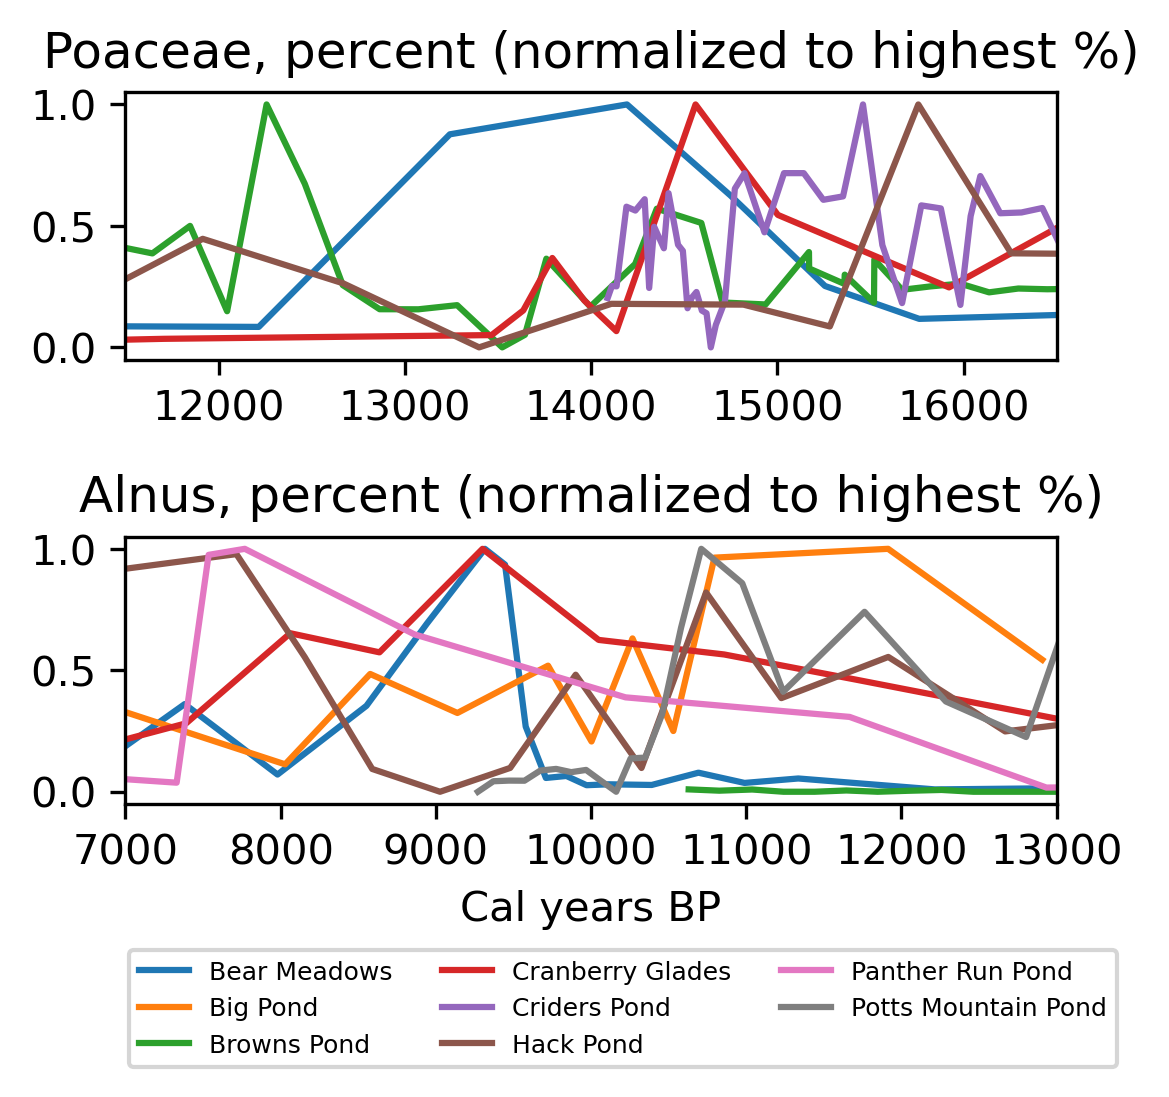

In [42]:
fig, ax = plt.subplots(2,1, figsize=(4,4), dpi=300)

for i, frame in enumerate(sitelist):
    ax[0].plot(frame['median'], (frame['Poaceae']/frame['Poaceae'].max()),label='poop') #the poop is necessary to make the label 
hand, lab = ax[0].get_legend_handles_labels()
ax[0].set_xlim(11500,16500)
ax[0].set_title("Poaceae, percent (normalized to highest %)")

for i, frame in enumerate(sitelist):
    ax[1].plot(frame['median'], (frame['Total Alnus']/frame['Total Alnus'].max()),label='poop') #the poop is necessary to make the label 
hand, lab = ax[1].get_legend_handles_labels() 
ax[1].set_xlim(7000,13000)
ax[1].set_title("Alnus, percent (normalized to highest %)")
ax[1].set_xlabel("Cal years BP")
ax[1].legend(hand,sitenamelist,loc='upper left', fontsize=6, ncol=3, bbox_to_anchor=(-0.01, -0.5))
fig.tight_layout()

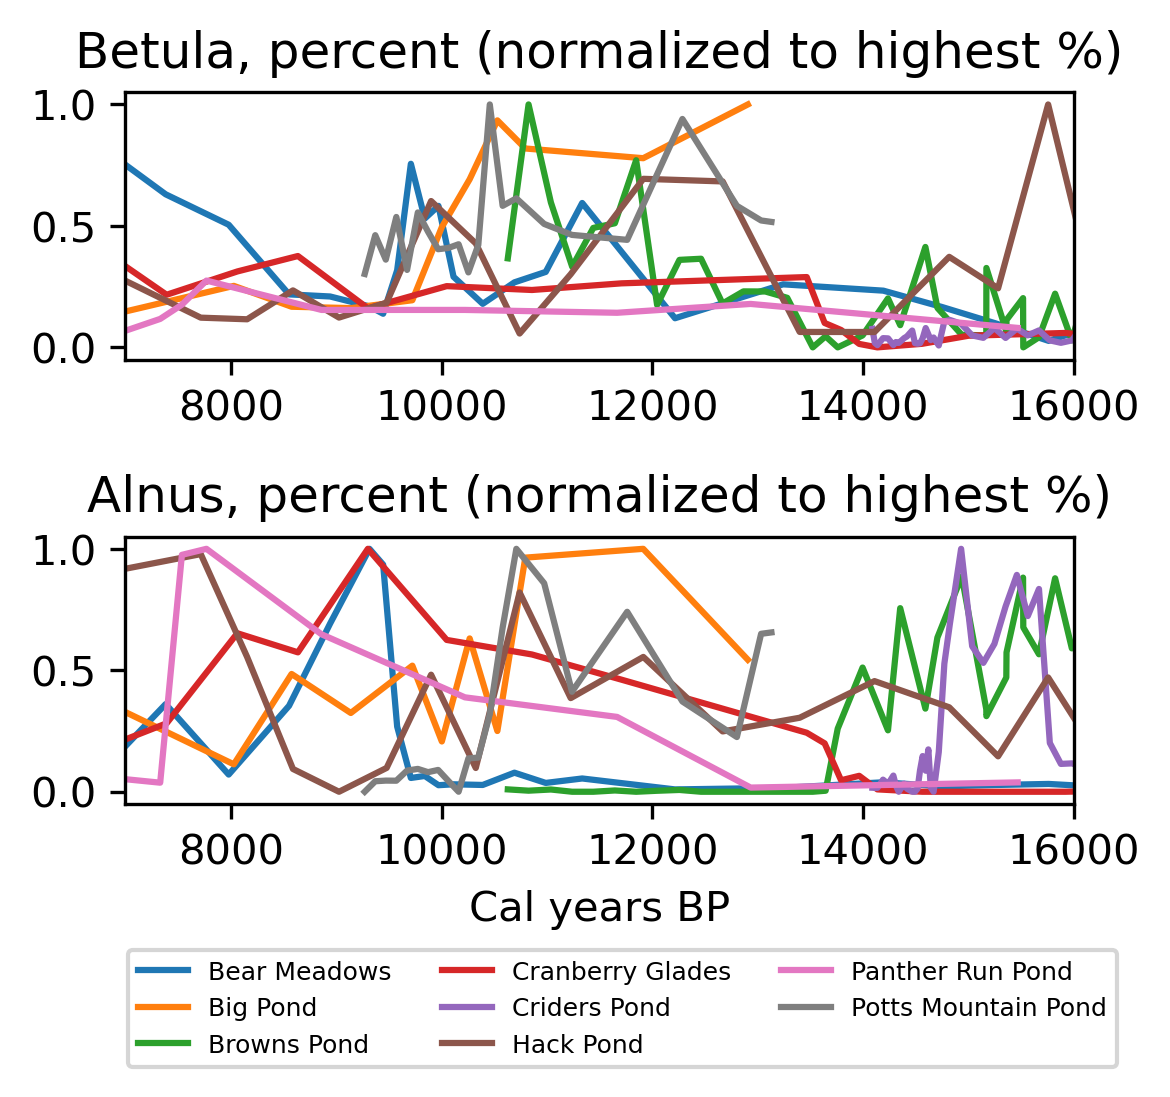

In [43]:
fig, ax = plt.subplots(2,1, figsize=(4,4), dpi=300)

for i, frame in enumerate(sitelist):
    ax[0].plot(frame['median'], (frame['Betula']/frame['Betula'].max()),label='poop') #the poop is necessary to make the label 
hand, lab = ax[0].get_legend_handles_labels()
ax[0].set_xlim(7000,16000)
ax[0].set_title("Betula, percent (normalized to highest %)")

for i, frame in enumerate(sitelist):
    ax[1].plot(frame['median'], (frame['Total Alnus']/frame['Total Alnus'].max()),label='poop') #the poop is necessary to make the label 
hand, lab = ax[1].get_legend_handles_labels() 
ax[1].set_xlim(7000,16000)
ax[1].set_title("Alnus, percent (normalized to highest %)")
ax[1].set_xlabel("Cal years BP")
ax[1].legend(hand,sitenamelist,loc='upper left', fontsize=6, ncol=3, bbox_to_anchor=(-0.01, -0.5))
fig.tight_layout()

# Pollen strat map


In [44]:
strat_path = "C:\\Users\\joanm\\OneDrive - Dartmouth College\\PSU_dissertation\\BMbog_paper\\bog_data_clean_for_plots\\regional_pollen_age_models_with_strat"

In [45]:
bear = pd.read_csv(os.path.join(strat_path, "stingelin_correlation_new.csv"))
bigpond = pd.read_csv(os.path.join(strat_path, "bigpond_pct.csv"), encoding='latin-1')
browns = pd.read_csv(os.path.join(strat_path, "browns_pct.csv"), encoding='latin-1')
cranb = pd.read_csv(os.path.join(strat_path, "cranb_pct.csv"), encoding='latin-1')
crider = pd.read_csv(os.path.join(strat_path, "crider_pct.csv"), encoding='latin-1')
hack = pd.read_csv(os.path.join(strat_path, "hack_pct.csv"), encoding='latin-1')
panther = pd.read_csv(os.path.join(strat_path, "panther_pct.csv"), encoding='latin-1')
potts = pd.read_csv(os.path.join(strat_path, "potts_pct.csv"), encoding='latin-1')

bear['median']=bear['Age 3']

sitelist = [bear, bigpond, browns, cranb, crider, hack, panther, potts]
sitenamelist = ['Bear Meadows', 'Big', 'Browns', 'Cranberry Glades', 'Criders',
                'Hacks', 'Panther Run', 'Potts Mountain']

for frame in sitelist:
    Alnus_cols = [col for col in frame.columns if 'Alnus' in col]
    frame['Total Alnus'] = frame[Alnus_cols].sum(axis=1)
    
for frame in sitelist:
    if 'Poaceae' not in frame.columns:
        frame['Poaceae'] = 0

## One time: export a list of unique lithology textures from Neotoma cores

In [46]:
lith_list = []

for frame in sitelist:
    Alnus_cols = [col for col in frame.columns if 'Alnus' in col]
    frame['Total Alnus'] = frame[Alnus_cols].sum(axis=1)
    
    if 'Poaceae' not in frame.columns:
        frame['Poaceae'] = 0

    lith_list.append(frame.strat.unique().tolist())
    
lith_list_flat = [item for sublist in lith_list for item in sublist]
#https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists

lith_list = list(set(lith_list_flat))
#https://stackoverflow.com/questions/4459703/how-to-make-lists-contain-only-distinct-element-in-python

print(lith_list)

###ll_df = pd.DataFrame(lith_list)
### Lol please do not overwrite this file 
###ll_df.to_csv((os.path.join(strat_path,"strat2.csv")))

['gray and brown silty clay', 'peaty silt', 'clay', 'peat with silt', 'peat', 'peaty sandy clay', 'fibrous peat', 'dark-brown copropel', 'organic clay with stones', 'banded silt', 'organic clay', 'red clay', 'gray silt', 'copropelic clay', 'sandy red colluvial clay', 'silty clay', 'gray clay', 'peaty clay', 'silt with black bands', 'sandy silt', 'organic silt', 'brown clay', 'silt with stones']


## Assign coarse strat to fine strat

This is after one time I go in and assign more universal strat terms to site-specific terms

In [47]:
strat2 = pd.read_csv(os.path.join(strat_path, "strat2.csv"))

strat_dict = pd.Series(strat2.coarse_strat.values, strat2.fine_strat.values,).to_dict()

sitenamelist = ['Bear Meadows', 'Big Pond', 'Browns Pond', 'Cranberry Glades', 'Criders Pond',
                'Hack Pond', 'Panther Run Pond', 'Potts Mountain Pond']

In [48]:
for frame in sitelist:
    frame['strat_coarse'] = frame['strat'].map(strat_dict)

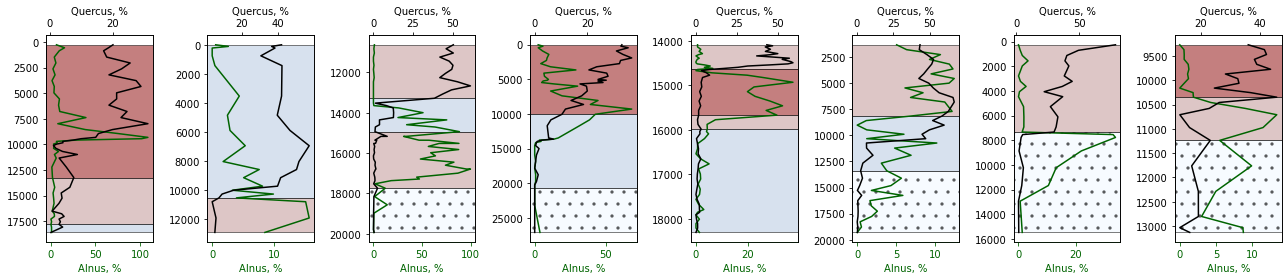

In [49]:
color_dict= {
    "coarse" : "aliceblue",
    "fine, inorg" : "lightsteelblue",
    "fine, org" : "rosybrown",
    "peat" : "darkred"
    
}

hatch_dict= {
    "coarse" : ".",
    "fine, inorg" : False,
    "fine, org" : False,
    "peat" : False
    
}

fig, ax = plt.subplots(1, len(sitelist), figsize=(18,4), sharey=False)


# Loop through each site
for i, frame in enumerate(sitelist):
    
    breaks_list = []
    texture_list = []
    
    # Loop through each time slice
    for j in range(1, len(frame)):
        if frame.strat_coarse.iloc[j] != frame.strat_coarse.iloc[j-1]:
            breaks_list.append(frame['median'].iloc[j])
            texture_list.append(frame['strat_coarse'].iloc[j])
    #Add first date
    breaks_list.insert(0,frame['median'].iloc[0])
    texture_list.insert(0,frame['strat_coarse'].iloc[0])
    #Add last date
    breaks_list.append(frame['median'].iloc[len(frame)-1])
    texture_list.append(frame['strat_coarse'].iloc[len(frame)-1])
#     print(sitenamelist[i])
#     print(breaks_list)
#     print(texture_list)
    
    # Loop through each facies break point
    for k in range(1, len(breaks_list)):
        ax[i].axhspan(breaks_list[k-1], breaks_list[k], 
                      facecolor=color_dict[texture_list[k-1]], 
                      hatch=hatch_dict[texture_list[k-1]], 
                      edgecolor="black", 
                      alpha=0.5)
    
    ax[i].plot(frame['Total Alnus'],frame['median'], color="darkgreen")
    ax[i].xaxis.label.set_color('darkgreen')
    ax[i].tick_params(axis='x', colors='darkgreen')
    ax[i].spines['bottom'].set_color('darkgreen')
    ax[i].set_xlabel('Alnus, %')
    ax[i].invert_yaxis()
    
    ax2 = ax[i].twiny()
    ax2.plot(frame['Quercus'],frame['median'], color="black")
    ax2.xaxis.label.set_color('black')
    ax2.tick_params(axis='x', colors='black')
    ax2.spines['top'].set_color('black')
    ax2.set_xlabel('Quercus, %')

fig.tight_layout()
#ax[0].set_ylim(20000,0)

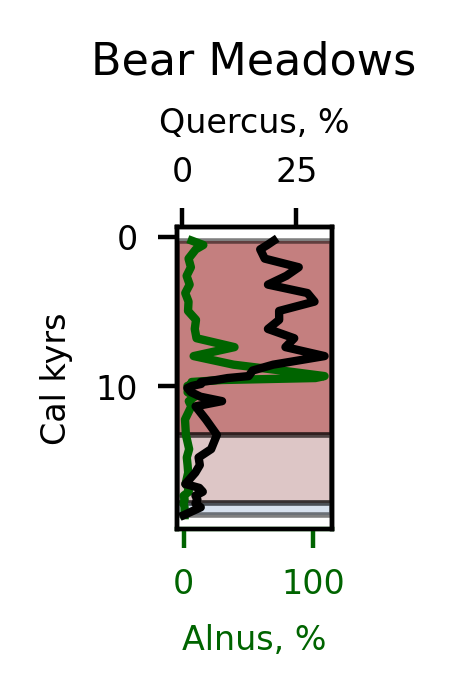

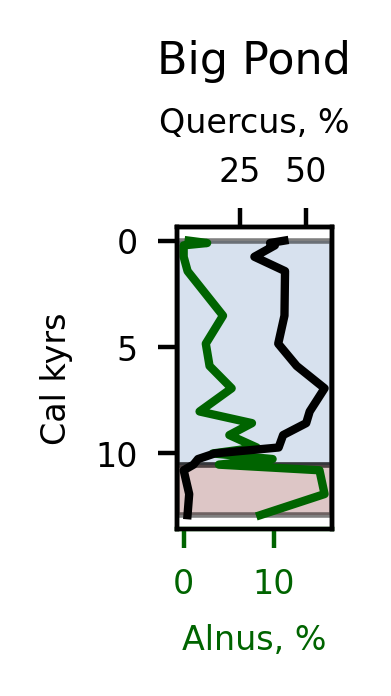

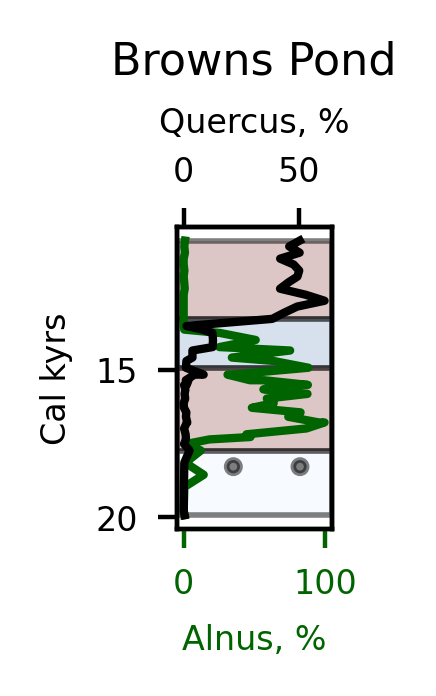

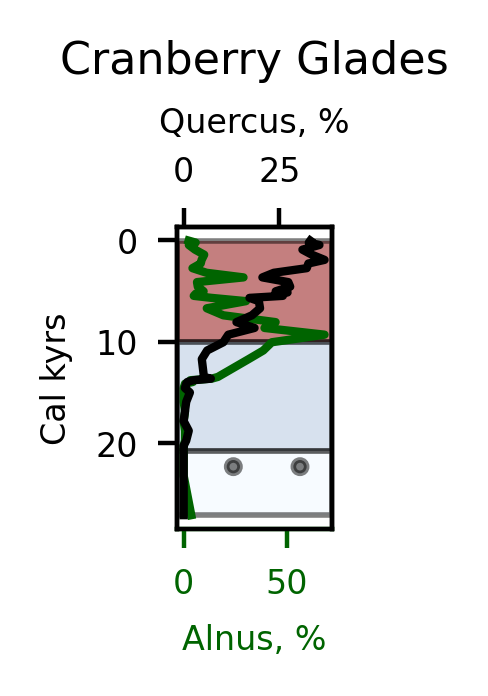

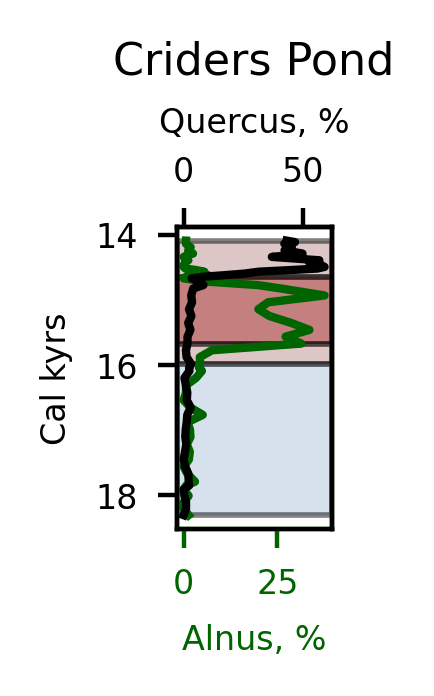

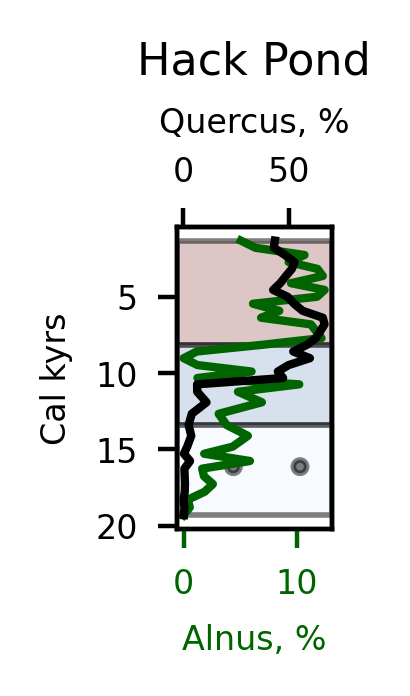

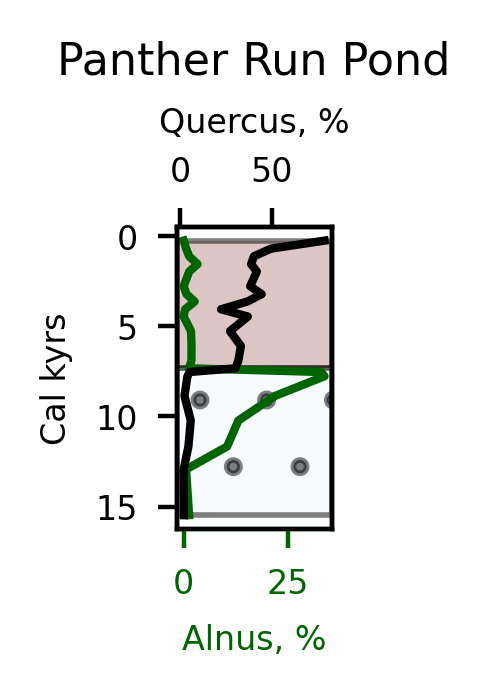

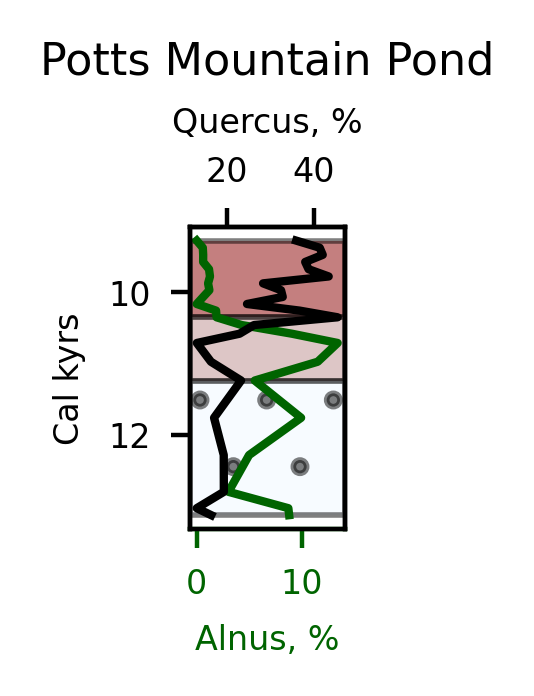

In [50]:
SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


color_dict= {
    "coarse" : "aliceblue",
    "fine, inorg" : "lightsteelblue",
    "fine, org" : "rosybrown",
    "peat" : "darkred"
    
}

hatch_dict= {
    "coarse" : ".",
    "fine, inorg" : False,
    "fine, org" : False,
    "peat" : False
    
}

# Loop through each site
for i, frame in enumerate(sitelist):

    frame['cal kyrs']=frame['median']/1000
    
    fig, ax = plt.subplots(figsize=(0.5,1), dpi=400, sharey=False)
    
    breaks_list = []
    texture_list = []
    
    # Loop through each time slice
    for j in range(1, len(frame)):
        if frame.strat_coarse.iloc[j] != frame.strat_coarse.iloc[j-1]:
            breaks_list.append(frame['cal kyrs'].iloc[j])
            texture_list.append(frame['strat_coarse'].iloc[j])
    #Add first date
    breaks_list.insert(0,frame['cal kyrs'].iloc[0])
    texture_list.insert(0,frame['strat_coarse'].iloc[0])
    #Add last date
    breaks_list.append(frame['cal kyrs'].iloc[len(frame)-1])
    texture_list.append(frame['strat_coarse'].iloc[len(frame)-1])
#     print(sitenamelist[i])
#     print(breaks_list)
#     print(texture_list)
    
    # Loop through each facies break point
    for k in range(1, len(breaks_list)):
        ax.axhspan(breaks_list[k-1], breaks_list[k], 
                      facecolor=color_dict[texture_list[k-1]], 
                      hatch=hatch_dict[texture_list[k-1]], 
                      edgecolor="black", 
                      alpha=0.5)
    
    ax.plot(frame['Total Alnus'],frame['cal kyrs'], color="darkgreen")
    ax.xaxis.label.set_color('darkgreen')
    ax.tick_params(axis='x', colors='darkgreen')
    ax.spines['bottom'].set_color('darkgreen')
    ax.set_xlabel('Alnus, %')
    ax.invert_yaxis()
    ax.set_ylabel('Cal kyrs')
    
    #ax.set_ylabel('Years cal kyrs')
    
    ax2 = ax.twiny()
    ax2.plot(frame['Quercus'],frame['cal kyrs'], color="black")
    ax2.xaxis.label.set_color('black')
    ax2.tick_params(axis='x', colors='black')
    ax2.spines['top'].set_color('black')
    ax2.set_xlabel('Quercus, %')
    ax.set_title(sitenamelist[i], fontsize=8)
    plt.savefig(os.path.join(strat_path,sitenamelist[i]+'.png'),bbox_inches = "tight")
    #fig.tight_layout()

## Map it

In [51]:
sites = pd.read_csv(os.path.join(strat_path, 'bacon_sites.csv'), encoding='cp1252')

geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
crs = {'init': 'epsg:4326 '}
geo_df = GeoDataFrame(sites, crs=crs, geometry=geometry)

C:\Users\joanm\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [52]:
gis_path = 'C:\\Users\\joanm\\OneDrive - Dartmouth College\\PSU_dissertation\\BMbog_paper\\bog_data_clean_for_plots\\bog_gis'

In [53]:
states = gpd.read_file(os.path.join(gis_path, 'cb_2018_us_state_20m.shp'))
#lith = gpd.read_file(os.path.join(gis_path, 'SGMC_Geology.shp'))
#lith = lith.to_crs(epsg=4326)
#lith_list = ['Sandstone','Conglomerate']

In [54]:
srtm = rasterio.open(os.path.join(gis_path, 'central_app_90m.tif'), masked=True)
dem_array = srtm.read(1)
#To do:
#https://anaconda.org/conda-forge/elevation
# Bounding box selection:
# minX, minY (-82.16674804687499, 36.302398675663454)
# maxX, maxY (-75.13549804687499, 42.281881034465016)
#https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/

In [ ]:
!eio clip -o central_app_download.tif --bounds -82.166 36.302 -75.135 42.281 

In [ ]:
srtm = rasterio.open(os.path.join(gis_path, 'central_app_download.tif'), masked=True)
dem_array = srtm.read(1)

In [55]:
# Create a discrete color map for elevation intervals
max_elev = 1200
step = 200

viridis = cm.get_cmap('viridis', int(max_elev/step))
newcolors = viridis(np.linspace(0, 1, int((max_elev/step)-1)))

# make a color map of fixed colors
cmap = colors.ListedColormap(newcolors)
bounds=(np.linspace(0,max_elev,step))
norm = colors.BoundaryNorm(bounds, cmap.N)

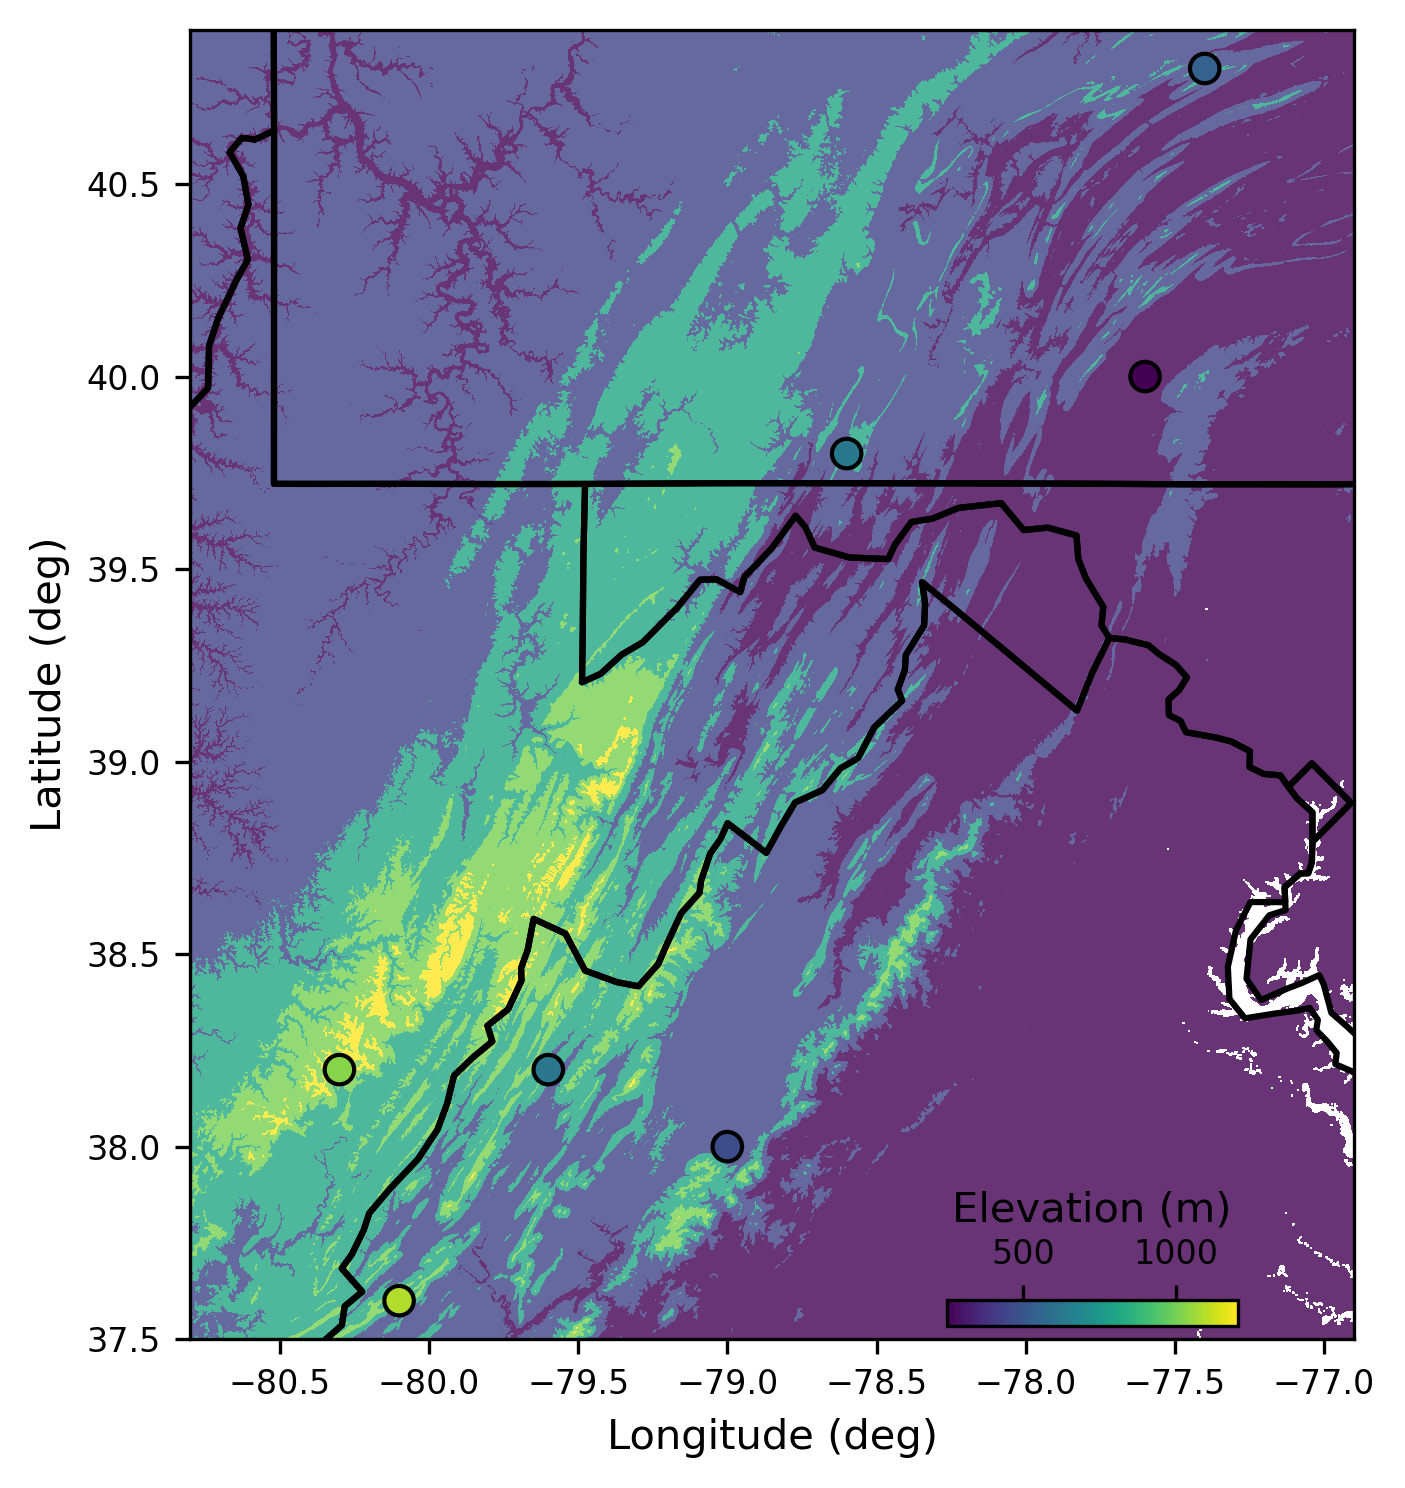

In [56]:


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, ax = plt.subplots(figsize=(5,5), dpi=300)


elev = rasterio.plot.show(srtm,
                         cmap=cmap, norm=norm,
                          alpha=0.8,
                          zorder=0,
                          ax=ax
                         )

borders = states.boundary.plot(ax=ax, color='k', zorder=1)
#lith[lith['MAJOR1'].isin(lith_list)].plot(column='AGE_MIN', ax=ax)
# divider = make_axes_locatable(ax)

# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbaxes = inset_axes(ax, width="30%", height="3%", loc='lower right', borderpad= 5.0) 

cbaxes = ax.inset_axes([0.65, 0.01, 0.25, 0.02])


pts = geo_df.plot(ax=ax, marker='o', column=geo_df['Elevation (m asl)'], markersize=50, edgecolor='k',
                  cax=cbaxes,
                  vmax=max_elev,
                  legend=True,
                  legend_kwds={'label': "Elevation (m)",
                               'orientation': "horizontal"})

cbaxes.tick_params(axis='x', which='both',bottom=False, top=True, labelbottom=False, labeltop=True)

cbaxes.xaxis.set_label_position('top')

ax.set_xlim(geo_df['Longitude'].min()-0.5,geo_df['Longitude'].max()+0.5)
ax.set_ylim(geo_df['Latitude'].min()-0.1,geo_df['Latitude'].max()+0.1)
ax.set_ylabel("Latitude (deg)")
ax.set_xlabel("Longitude (deg)")
fig.tight_layout()

plt.savefig(os.path.join(strat_path,'strat_map.png'))

# Supplement figures 

## All pollen data as time series

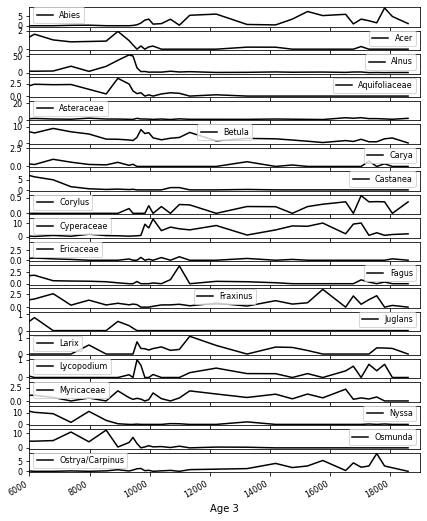

In [57]:
pollen = dfs.columns[ 4:(-4-18)]
#pollen_data.head()
# fig, ax = plt.subplots()
#plt.plot(x=dfs['Age 3'], y=pollen_data,figsize=(10,50))
ax = dfs.plot(x='Age 3', y=pollen, subplots=True, figsize=(7,9.5), color='k', xlim=(6000,19000));
fig = ax[0].get_figure()
#fig.tight_layout()
fig.savefig('bog_time_allpollen_1.png', dpi=300, bbox_inches='tight')

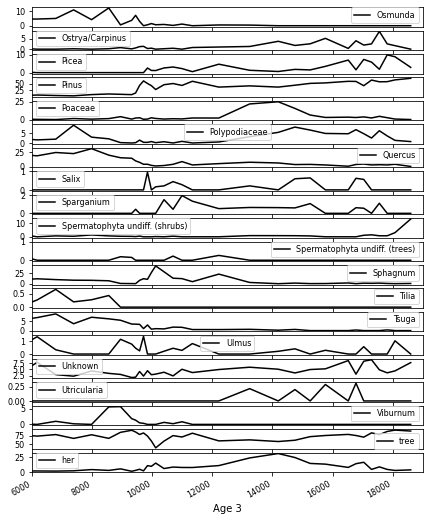

In [58]:
pollen = dfs.columns[ (4+18):(-4)]
#pollen_data.head()
# fig, ax = plt.subplots()
#plt.plot(x=dfs['Age 3'], y=pollen_data,figsize=(10,50))
ax = dfs.plot(x='Age 3', y=pollen, subplots=True, figsize=(7,9.5), color='k', xlim=(6000,19000));
fig = ax[0].get_figure()
#fig.tight_layout()
fig.savefig('bog_time_allpollen_2.png', dpi=300, bbox_inches='tight')

## PC1 vs C_org

C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  from ipykernel import kernelapp as app


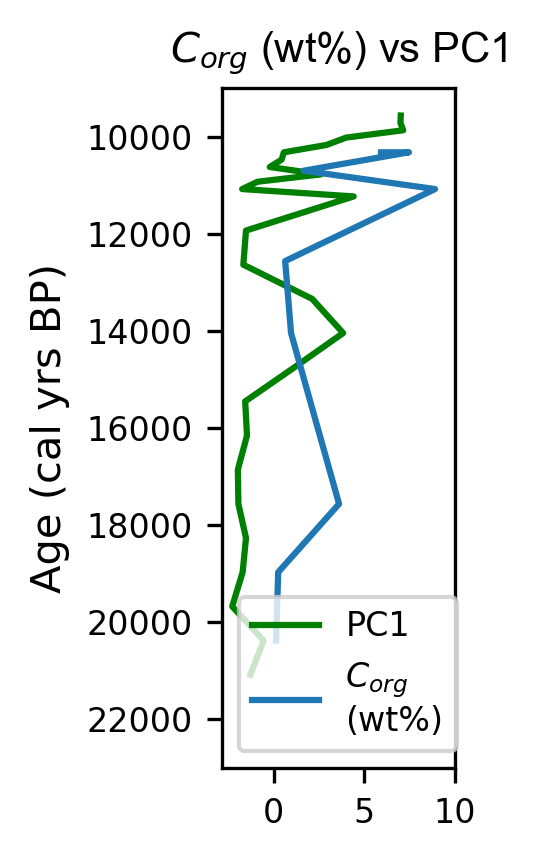

In [59]:
pd.to_numeric(df["depth_adj"])
result0=df[['depth_adj','age_extrapolated']]
result=dfo_red.merge(result0,how='left',left_on='depth_adj', right_on='depth_adj')
result=result.interpolate(method='linear',limit_direction='backward')

fig, ax = plt.subplots(figsize=(1,3), dpi=300)
ax.plot( agePCA.PC1, agePCA.age_extrapolated,'g', label='PC1')
ax.plot(result['%C'],result['age_extrapolated'], label='$C_{org}$\n(wt%)')
ax.set_title('$C_{org}$ (wt%) vs PC1',fontsize=10, fontname='Arial')
ax.set_xticks(range(0,11,5))
ax.legend(fontsize=8)
ax.set_ylabel('Age (cal yrs BP)')
ax.set_ylim(23000, 9000)

fig.tight_layout()
fig.savefig('C_org_vs_PC1.png', dpi=300, bbox_inches='tight')

## Extra PCAs

In [60]:
# Create essentially new data frame from XRF scans to get element values only
el_cols = []

for x in range (0, int((len(df.columns)-9)/2)):
    el_cols.append(10+2*x)

element_data = df.iloc[:, el_cols+[5, 6]]
#element_data = df.iloc[:, el_cols]
element_data = element_data.drop(columns=['age_extrapolated'])

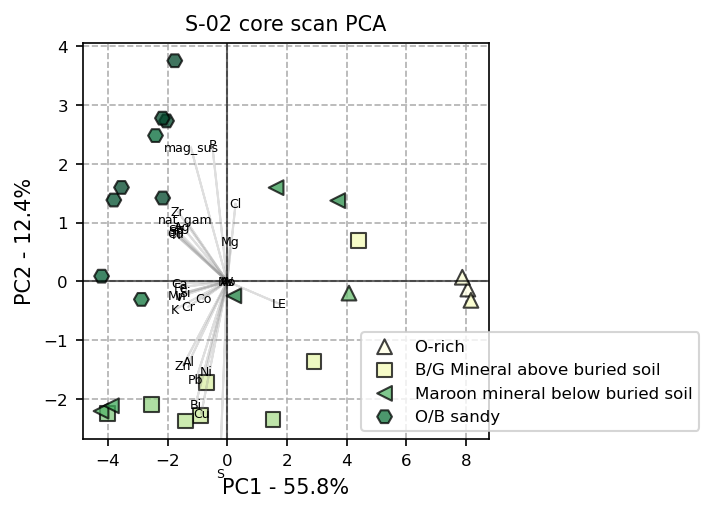

In [61]:
scaled_data = preprocessing.scale(element_data)

# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)
# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# the loading scores are the proportions that make up the PCs
loading_scores1 = pd.Series(pca.components_[0], index=element_data.columns)
loading_scores2 = pd.Series(pca.components_[1], index=element_data.columns)
loading_scores3 = pd.Series(pca.components_[2], index=element_data.columns)
loading_scores = pd.concat([loading_scores1,loading_scores2,loading_scores3],axis=1)

sorted_loading_scores1 = loading_scores1.abs().sort_values(ascending=False)
top_10_1 = sorted_loading_scores1[0:].index.values
loading_scores1[top_10_1];

pca_df = pd.DataFrame(pca_data, index=element_data.index,columns=labels)
pca_df = pd.merge(pca_df,df['unit_desc'],left_index=True, right_index=True)

cluster_list = df2['depth_adj'].unique()
# set colormap
low = 0
high = 1.25
number_of_lines= len(cluster_list)
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap("YlGn")
c_list = [ cmap(x) for x in cm_subsection ]
c_list[:-1]
lut = dict(zip(cluster_list, c_list))
colors = df2['depth_adj'].map(lut)


sym_list = ['^','s','<','H','D']
sut = dict(zip(df2['unit_desc'].unique(), sym_list))
symbols = df2['unit_desc'].map(sut)


coeff = np.transpose(pca.components_[[0,1], :]) # take the first two PCs
fig, ax = pcaplot('unit_desc',pca_df, coeff=coeff, per_var=per_var,
                  colors=colors,sym_list=sym_list,labels=loading_scores.index)
ax.legend(loc='lower center', bbox_to_anchor=(1.1, 0), fontsize=8)

ax.set_title('S-02 core scan PCA',fontsize=10)
fig.savefig('PCA_bog_only.png', dpi=300,bbox_inches='tight')

(0.01, 100.0)

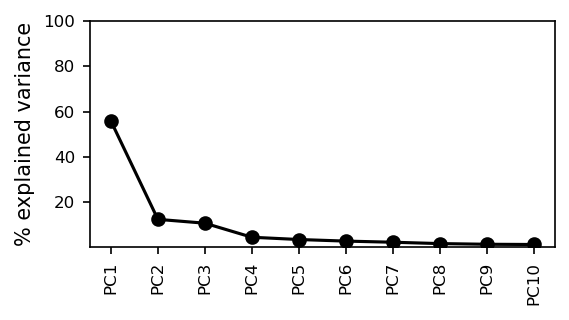

In [62]:
scaled_data = preprocessing.scale(element_data)
# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)

# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# Plotting only top 10 PCs
fig, ax = plt.subplots(figsize=(4,2),dpi=150)
# ax.axhline(8,ls='--',c='r')
# ax.bar(x=total_pcs, height=per_var, tick_label=labels,color='k')
p_l = ax.plot(total_pcs[0:10],per_var[0:10],'-o',c='k')
# c_l = ax.plot(total_pcs,cum_per_var,'-^',c='lightgray')
ax.set_xticks(total_pcs[0:10])
ax.set_xticklabels(labels,rotation=90);
ax.set_ylabel('% explained variance')
#ax.set_yscale('log')
ax.set_ylim(.01,100)

# look for a "kink" in the plot

(0.01, 100.0)

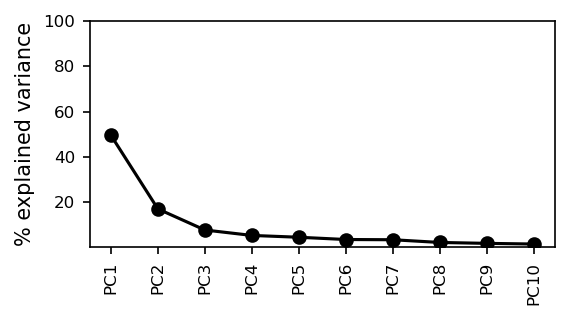

In [63]:
df2 = pd.read_csv("hs_core_cleaned.csv")
hs_cols = []
hs_data = df2.iloc[:, 8:] #heavies and lights
hs_data = hs_data.dropna(axis=1)


scaled_data = preprocessing.scale(hs_data)
# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)

# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# Plotting only top 10 PCs
fig, ax = plt.subplots(figsize=(4,2),dpi=150)
# ax.axhline(8,ls='--',c='r')
# ax.bar(x=total_pcs, height=per_var, tick_label=labels,color='k')
p_l = ax.plot(total_pcs[0:10],per_var[0:10],'-o',c='k')
# c_l = ax.plot(total_pcs,cum_per_var,'-^',c='lightgray')
ax.set_xticks(total_pcs[0:10])
ax.set_xticklabels(labels,rotation=90);
ax.set_ylabel('% explained variance')
#ax.set_yscale('log')
ax.set_ylim(.01,100)

# look for a "kink" in the plot

(0.01, 100.0)

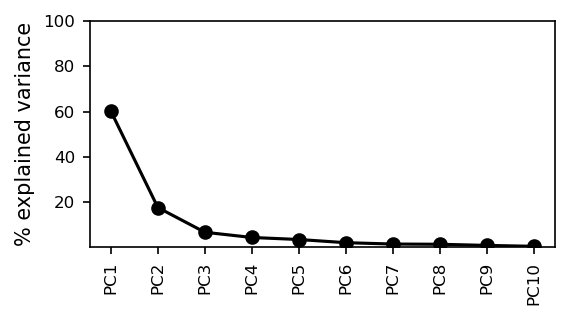

In [64]:
df2 = pd.read_csv("hs_core_cleaned.csv")
hs_cols = []
hs_data = df2.iloc[:, 8:] #heavies and lights
hs_data = hs_data.dropna(axis=1)


scaled_data = preprocessing.scale(hs_data[hi_threshold_elements])
# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)

# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# Plotting only top 10 PCs
fig, ax = plt.subplots(figsize=(4,2),dpi=150)
# ax.axhline(8,ls='--',c='r')
# ax.bar(x=total_pcs, height=per_var, tick_label=labels,color='k')
p_l = ax.plot(total_pcs[0:10],per_var[0:10],'-o',c='k')
# c_l = ax.plot(total_pcs,cum_per_var,'-^',c='lightgray')
ax.set_xticks(total_pcs[0:10])
ax.set_xticklabels(labels,rotation=90);
ax.set_ylabel('% explained variance')
#ax.set_yscale('log')
ax.set_ylim(.01,100)

# look for a "kink" in the plot

(0.01, 100.0)

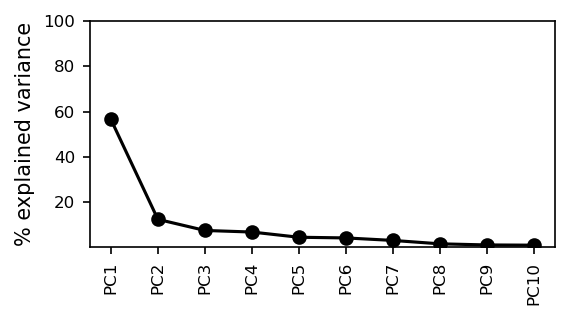

In [65]:
df2 = pd.read_csv("hs_core_cleaned.csv")
hs_cols = []
hs_data = df2.iloc[:, 8:] #heavies and lights
hs_data = hs_data.dropna(axis=1)


scaled_data = preprocessing.scale(hs_data[heavy_elements])
# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)

# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# Plotting only top 10 PCs
fig, ax = plt.subplots(figsize=(4,2),dpi=150)
# ax.axhline(8,ls='--',c='r')
# ax.bar(x=total_pcs, height=per_var, tick_label=labels,color='k')
p_l = ax.plot(total_pcs[0:10],per_var[0:10],'-o',c='k')
# c_l = ax.plot(total_pcs,cum_per_var,'-^',c='lightgray')
ax.set_xticks(total_pcs[0:10])
ax.set_xticklabels(labels,rotation=90);
ax.set_ylabel('% explained variance')
#ax.set_yscale('log')
ax.set_ylim(.01,100)

# look for a "kink" in the plot

Text(0.5, 0, 'Years before present')

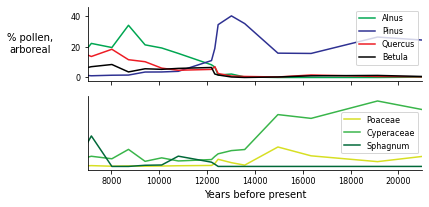

In [66]:
dfcr= pd.read_csv("cranberry_pollen.csv")

fig, ax = plt.subplots(2,1,figsize=(6,3),sharex=True, frameon=False)
# fig, ax = plt.subplots(2,4)


#ax[1].plot(dfs['mean age'],(dfs['Abies']+dfs['Picea']),label='Abies+Picea')
ax[0].plot(dfcr['age'],(dfcr['Alnus']), label='Alnus', color='#00A651')
ax[0].plot(dfcr['age'],(dfcr['Pinus']), label='Pinus', color='#2E3192')
ax[0].plot(dfcr['age'],(dfcr['Quercus']), label = 'Quercus', color='#ED1C24')
ax[0].plot(dfcr['age'],(dfcr['Betula']), label = 'Betula', color='k')
#ax[1].plot(dfs['mean age'],(dfs['Tsuga']))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
#ax[0].set_yticks([0,30,60])
#ax[1].spines['bottom'].set_visible(False)
ax[0].legend()
ax[0].set_ylabel('% pollen,\narboreal', rotation=0, labelpad=40, va='center')
ax[0].legend()
# h, l = ax[1].get_legend_handles_labels()
#ax[1].legend(labels = [l])

ax[1].plot(dfcr['age'],(dfcr['Poaceae']), label='Poaceae', color='#D7DF23')
ax[1].plot(dfcr['age'],(dfcr['Cyperaceae']), label='Cyperaceae', color='#39B54A')
ax[1].plot(dfcr['age'],(dfcr['Sphagnum']), label='Sphagnum', color='#006838')
ax[1].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
#ax[1].set_yticks([0,20,40])
ax[1].legend()
#ax[2].spines['bottom'].set_visible(False)
ax[1].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].yaxis.set_visible(False)
# ax[6].set_yticklabels([])
# ax[6].set_yticks([])
# ax[6].set_ylabel('bog center\n\n\n\nbog edge',rotation=0, labelpad=40, va='center')
#ax[1].set_ylim([-.1,1])

ax[1].set_xlim(7000,21000)
ax[1].set_xlabel('Years before present')
#ax[0].set_xticks(range(6000,22000,2000))

# fig.tight_layout()

#fig.savefig('bog_time_data_new.svg', dpi=300)


Text(0.5, 0, 'Years before present')

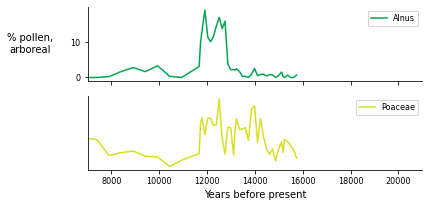

In [67]:
dfc= pd.read_csv("crider_pollen.csv")

fig, ax = plt.subplots(2,1,figsize=(6,3),sharex=True, frameon=False)
# fig, ax = plt.subplots(2,4)


#ax[1].plot(dfs['mean age'],(dfs['Abies']+dfs['Picea']),label='Abies+Picea')
ax[0].plot(dfc['age'],(dfc['Alnus']), label='Alnus', color='#00A651')
#ax[0].plot(dfc['age'],(dfc['Pinus']), label='Pinus', color='#2E3192')
#ax[0].plot(dfc['age'],(dfc['Quercus']), label = 'Quercus', color='#ED1C24')
#ax[0].plot(dfc['age'],(dfc['Betula']), label = 'Quercus', color='k')
#ax[1].plot(dfs['mean age'],(dfs['Tsuga']))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
#ax[0].set_yticks([0,30,60])
#ax[1].spines['bottom'].set_visible(False)
ax[0].legend()
ax[0].set_ylabel('% pollen,\narboreal', rotation=0, labelpad=40, va='center')
ax[0].legend()
# h, l = ax[1].get_legend_handles_labels()
#ax[1].legend(labels = [l])

ax[1].plot(dfc['age'],(dfc['Poaceae']), label='Poaceae', color='#D7DF23')
#ax[1].plot(dfc['age'],(dfc['Cyperaceae']), label='Cyperaceae', color='#39B54A')
#ax[1].plot(dfc['age'],(dfc['Sphagnum']), label='Sphagnum', color='#006838')
ax[1].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
#ax[1].set_yticks([0,20,40])
ax[1].legend()
#ax[2].spines['bottom'].set_visible(False)
ax[1].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].yaxis.set_visible(False)
# ax[6].set_yticklabels([])
# ax[6].set_yticks([])
# ax[6].set_ylabel('bog center\n\n\n\nbog edge',rotation=0, labelpad=40, va='center')
#ax[1].set_ylim([-.1,1])

ax[1].set_xlim(7000,21000)
ax[1].set_xlabel('Years before present')
#ax[0].set_xticks(range(6000,22000,2000))

# fig.tight_layout()

#fig.savefig('bog_time_data_new.svg', dpi=300)

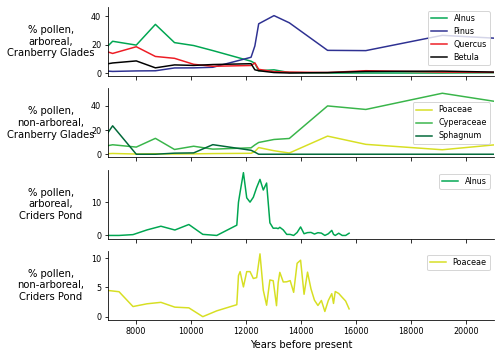

In [68]:
fig, ax = plt.subplots(4,1,figsize=(7,5),sharex=True, frameon=False)
#ax[1].plot(dfs['mean age'],(dfs['Abies']+dfs['Picea']),label='Abies+Picea')
ax[0].plot(dfcr['age'],(dfcr['Alnus']), label='Alnus', color='#00A651')
ax[0].plot(dfcr['age'],(dfcr['Pinus']), label='Pinus', color='#2E3192')
ax[0].plot(dfcr['age'],(dfcr['Quercus']), label = 'Quercus', color='#ED1C24')
ax[0].plot(dfcr['age'],(dfcr['Betula']), label = 'Betula', color='k')
#ax[1].plot(dfs['mean age'],(dfs['Tsuga']))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
#ax[0].set_yticks([0,30,60])
#ax[1].spines['bottom'].set_visible(False)
ax[0].legend()
ax[0].set_ylabel('% pollen,\narboreal,\nCranberry Glades', rotation=0, labelpad=40, va='center')

ax[0].legend()
# h, l = ax[1].get_legend_handles_labels()
#ax[1].legend(labels = [l])

ax[1].plot(dfcr['age'],(dfcr['Poaceae']), label='Poaceae', color='#D7DF23')
ax[1].plot(dfcr['age'],(dfcr['Cyperaceae']), label='Cyperaceae', color='#39B54A')
ax[1].plot(dfcr['age'],(dfcr['Sphagnum']), label='Sphagnum', color='#006838')
ax[1].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
#ax[1].set_yticks([0,20,40])
ax[1].legend()
#ax[2].spines['bottom'].set_visible(False)
ax[1].set_ylabel('% pollen,\nnon-arboreal,\nCranberry Glades', rotation=0, labelpad=40, va='center')

# ax[1].spines['top'].set_visible(False)
# ax[1].spines['right'].set_visible(False)
# ax[1].yaxis.set_visible(False)
# ax[6].set_yticklabels([])
# ax[6].set_yticks([])
# ax[6].set_ylabel('bog center\n\n\n\nbog edge',rotation=0, labelpad=40, va='center')
#ax[1].set_ylim([-.1,1])

ax[1].set_xlim(7000,21000)










#ax[1].plot(dfs['mean age'],(dfs['Abies']+dfs['Picea']),label='Abies+Picea')
ax[2].plot(dfc['age'],(dfc['Alnus']), label='Alnus', color='#00A651')
#ax[0].plot(dfc['age'],(dfc['Pinus']), label='Pinus', color='#2E3192')
#ax[0].plot(dfc['age'],(dfc['Quercus']), label = 'Quercus', color='#ED1C24')
#ax[0].plot(dfc['age'],(dfc['Betula']), label = 'Quercus', color='k')
#ax[1].plot(dfs['mean age'],(dfs['Tsuga']))
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
#ax[0].set_yticks([0,30,60])
#ax[1].spines['bottom'].set_visible(False)
ax[2].legend()
ax[2].set_ylabel('% pollen,\narboreal,\nCriders Pond', rotation=0, labelpad=40, va='center')
ax[2].legend()
# h, l = ax[1].get_legend_handles_labels()
#ax[1].legend(labels = [l])

ax[3].plot(dfc['age'],(dfc['Poaceae']), label='Poaceae', color='#D7DF23')
#ax[1].plot(dfc['age'],(dfc['Cyperaceae']), label='Cyperaceae', color='#39B54A')
#ax[1].plot(dfc['age'],(dfc['Sphagnum']), label='Sphagnum', color='#006838')
ax[3].set_ylabel('% pollen,\nnon-arboreal,\nCriders Pond', rotation=0, labelpad=40, va='center')
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
#ax[1].set_yticks([0,20,40])
ax[3].legend()
#ax[2].spines['bottom'].set_visible(False)


# ax[3].spines['top'].set_visible(False)
# ax[3].spines['right'].set_visible(False)
# ax[3].yaxis.set_visible(False)
# ax[6].set_yticklabels([])
# ax[6].set_yticks([])
# ax[6].set_ylabel('bog center\n\n\n\nbog edge',rotation=0, labelpad=40, va='center')
#ax[1].set_ylim([-.1,1])

ax[3].set_xlim(7000,21000)
ax[3].set_xlabel('Years before present')
#ax[0].set_xticks(range(6000,22000,2000))

fig.tight_layout()

fig.savefig('Criders_Cranberry_RBacon.png', dpi=300)